**Описание проекта**

Компания «Работа с заботой» оказывает услуги HR-аналитики другим бизнесам: она помогает прогнозировать увольнения сотрудников и разрабатывать меры для повышения удержания персонала. Это важно, потому что потеря сотрудников, особенно ключевых, ведёт к значительным затратам: от простоя в работе до дорогостоящего повторного найма и обучения.

Однако в крупных компаниях не всегда возможно оперативно собирать актуальные данные от всех сотрудников. Например, уровень удовлетворённости работой оценивается на основе регулярных опросов, которые требуют времени и ресурсов. Чтобы минимизировать издержки и получить прогностические оценки, компания хочет использовать модели машинного обучения.

**Задача 1:**

Прогноз удовлетворённости работой (регрессия)
Построить модель, которая будет предсказывать уровень удовлетворённости сотрудника работой (job_satisfaction_rate) по другим характеристикам.
Это позволит компании предсказывать потенциальное снижение мотивации и вовремя реагировать.

- Метрика: SMAPE (Symmetric Mean Absolute Percentage Error)
- Критерий успеха: SMAPE ≤ 15

**Задача 2:**

Прогноз увольнения (классификация)
Используя те же признаки (и дополнительно — предсказанную удовлетворённость), построить модель, которая определяет, уволится ли сотрудник в ближайшее время (quit).

Это поможет HR-отделу заранее предпринимать меры по удержанию персонала.

- Метрика: ROC-AUC
- Критерий успеха: ROC-AUC ≥ 0.91

**Входные данные:**

Компания предоставила:

- Личные и рабочие характеристики сотрудников (отдел, уровень должности, зарплата и др.)

- Историю повышения, нарушений и оценок руководителей

- Удовлетворённость и факты увольнения

**План работы**

**Часть 1 — Удовлетворённость сотрудников**

Загрузка данных train_job_satisfaction_rate.csv, test_features.csv, test_target_job_satisfaction_rate.csv

Предобработка данных

Исследовательский анализ

Подготовка данных в пайплайне (2 кодировщика)

Обучение моделей (Linear + DecisionTree)
- Подбор гиперпараметров
- Реализация метрики SMAPE
- Выбор лучшей модели

Прогноз на тесте + проверка метрики

Выводы по первой задаче

**Часть 2 — Прогноз увольнения**

Загрузка train_quit.csv, test_target_quit.csv

Предобработка, EDA + портрет ушедшего сотрудника

Проверка связи job_satisfaction_rate ↔ quit

Добавление предсказанной удовлетворённости в признаки

Подготовка в пайплайне (снова 2 кодировщика)

Обучение 3 моделей (гиперпараметры для 2 из них)

Метрика: ROC-AUC ≥ 0.91

Выводы по второй задаче

**Общие выводы**

Предложения для бизнеса

## Инсталы

In [1]:
!pip install -U scikit-learn

     |████████████████████████████████| 13.5 MB 2.2 MB/s eta 0:00:01
     |████████████████████████████████| 307 kB 92.8 MB/s eta 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1


In [2]:
pip install phik

     |████████████████████████████████| 686 kB 1.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


## Импорты

In [3]:
# Базовые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# PhiK-корреляция
from phik import phik_matrix

# Предобработка
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Модели
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC

# Кросс-валидация и подбор параметров
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

# Метрики
from sklearn.metrics import make_scorer, roc_auc_score

# Dummy модели
from sklearn.dummy import DummyRegressor, DummyClassifier

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [4]:
# Проверка версии
print(sklearn.__version__)

1.6.1


## Задача 1: предсказание уровня удовлетворённости сотрудника

## Шаг 1: Загрузка и первичный анализ данных

In [5]:
# Пути к файлам
train_path = 'https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv'
test_features_path = 'https://code.s3.yandex.net/datasets/test_features.csv'
test_target_path = 'https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv'

# Загрузка данных
train_df = pd.read_csv(train_path)
test_features_df = pd.read_csv(test_features_path)
test_target_df = pd.read_csv(test_target_path)

In [6]:
# Проверим размерности загруженных таблиц
print('train_job_satisfaction_rate.csv:', train_df.shape)
print('test_features.csv:', test_features_df.shape)
print('test_target_job_satisfaction_rate.csv:', test_target_df.shape)


# Просмотр первых строк каждой таблицы
print('\nТаблица train_job_satisfaction_rate.csv:')
display(train_df.head())

print('Таблица test_features.csv:')
display(test_features_df.head())

print('Таблица test_target_job_satisfaction_rate.csv:')
display(test_target_df.head())


# Первые строки и информация о типах данных
print("\n========== train_df.info() ==========\n")
train_df.info()
print("\n========== test_features_df.info() ==========\n")
test_features_df.info()
print("\n========== test_target_df.info() ==========\n")
test_target_df.info()

train_job_satisfaction_rate.csv: (4000, 10)
test_features.csv: (2000, 9)
test_target_job_satisfaction_rate.csv: (2000, 2)

Таблица train_job_satisfaction_rate.csv:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Таблица test_features.csv:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Таблица test_target_job_satisfaction_rate.csv:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08



========== train_df.info() ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB

========== test_features_df.info() ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column

Размерности таблиц:

train_df — обучающая выборка: 4000 строк × 10 столбцов

test_features_df — признаки для прогноза: 2000 строк × 9 столбцов

test_target_df — целевой признак (с id): 2000 строк × 2 столбца

Типы признаков:

Категориальные (object): dept, level, workload, last_year_promo, last_year_violations

Числовые (int, float): employment_years, supervisor_evaluation, salary, job_satisfaction_rate

Обе выборки имеют идентичную структуру, признаки распределены по типам логично. **Однако есть проблемы с пропускаи в данных:**

- Признак: dept, 6 пропусков в train, 2 пропуска в test.
- Признак: level, 4 пропуска в train, 1 пропуск в test.

## Шаг 2. Предобработка данных
Изучите данные и сделайте выводы. При необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

Далее проверим полные дубликаты, уникальные значения и распределения категориальных признаков.

In [7]:
# Проверка дубликатов по всем строкам
print(f"Число полных дубликатов в train_df: {train_df.duplicated().sum()}")
print(f"Число полных дубликатов в test_features_df: {test_features_df.duplicated().sum()}")

# Проверка дубликатов по id (должен быть уникальным)
print(f"\nУникальных id в train_df: {train_df['id'].nunique()} (всего строк: {len(train_df)})")
print(f"Уникальных id в test_features_df: {test_features_df['id'].nunique()} (всего строк: {len(test_features_df)})")


Число полных дубликатов в train_df: 0
Число полных дубликатов в test_features_df: 0

Уникальных id в train_df: 4000 (всего строк: 4000)
Уникальных id в test_features_df: 2000 (всего строк: 2000)


Дубликаты:

Полные дубликаты: не обнаружены ни в обучающей (train_df), ни в тестовой (test_features_df) выборке.

Уникальность id: 

Все идентификаторы уникальны в обеих выборках. Это подтверждает целостность и корректность структуры данных, и позволяет использовать id в дальнейшем для сопоставления результатов.

**Выведем уникальные значения для каждого категориального признака и в train_df, и в test_features_df**

In [8]:
cat_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for df, name in [(train_df, 'train_df'), (test_features_df, 'test_features_df')]:
    print(f"\n=== Уникальные значения в {name} ===")
    for col in cat_features:
        counts = df[col].value_counts(dropna=False)
        print(f"\n{col} ({len(counts)} уникальных значений):")
        print(counts)



=== Уникальные значения в train_df ===

dept (6 уникальных значений):
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
NaN              6
Name: dept, dtype: int64

level (4 уникальных значений):
junior    1894
middle    1744
sinior     358
NaN          4
Name: level, dtype: int64

workload (3 уникальных значений):
medium    2066
low       1200
high       734
Name: workload, dtype: int64

last_year_promo (2 уникальных значений):
no     3880
yes     120
Name: last_year_promo, dtype: int64

last_year_violations (2 уникальных значений):
no     3441
yes     559
Name: last_year_violations, dtype: int64

=== Уникальные значения в test_features_df ===

dept (7 уникальных значений):
sales         763
technology    455
marketing     279
purchasing    273
hr            227
NaN             2
                1
Name: dept, dtype: int64

level (4 уникальных значений):
junior    974
middle    854
sinior    171
NaN         1
Name: level, dtype: int64

work

1. Признак dept

В train_df: 6 категорий + NaN.

В test_features_df: 7 значений, включая пустую строку (''), которая не встречалась в train_df.

Нужно заменить пустую строку на NaN и убедиться, что все значения из test присутствуют в train.

2. Признак level

В обоих: 3 категории (junior, middle, sinior) + NaN.

Присутствует опечатка: sinior вместо senior. Нужно исправить опечатку во всех датасетах на корректную категорию senior.

3. Признак workload

В train_df: 3 категории (low, medium, high). В test_features_df: 4 значения, включая пустую строку ('').

Нужно заменить пустую строку на NaN, чтобы привести к единому формату.

4. Признак last_year_promo (бинарный признак)

Значения: yes / no в обеих выборках. Пропусков нет. Всё корректно.

5. Признак last_year_violations (бинарный признак)

Значения: yes / no в обеих выборках. Пропусков нет. Всё корректно.

**Посмотрим только на те категории, которые есть в тесте, но отсутствуют в трейне**

In [9]:
for col in cat_features:
    train_vals = set(train_df[col].dropna().unique())
    test_vals  = set(test_features_df[col].dropna().unique())
    diff = test_vals - train_vals
    if diff:
        print(f"\nВ test_features_df в '{col}' есть новые категории, отсутствующие в train_df: {diff}")



В test_features_df в 'dept' есть новые категории, отсутствующие в train_df: {' '}

В test_features_df в 'workload' есть новые категории, отсутствующие в train_df: {' '}


Выводы:

Пустые строки (' ') в dept и workload должны быть заменены на NaN. Опечатка 'sinior' в признаке level — далее будет исправлена в обоих датафреймах вручную.

Пропуски в dept и level (обе выборки) — **будут заполнены 'unknown' в пайплайне как требуется в задании.** 

In [10]:
# Создаём копии таблиц, чтобы сохранить оригиналы нетронутыми
# Сразу ставим 'id' как индекс
train_cleaned = train_df.set_index('id').copy()
test_cleaned = test_features_df.set_index('id').copy()
test_target_df = test_target_df.set_index('id').copy()

In [11]:
# Сортируем оба по индексу id
test_cleaned = test_cleaned.sort_index()
test_target_df = test_target_df.sort_index()

# Исправляем опечатку и обрабатываем пустые строки в обоих датафреймах
for df in (train_cleaned, test_cleaned):
    # Исправляем опечатку 'sinior' → 'senior'
    df['level'] = df['level'].replace('sinior', 'senior')
    # Заменяем пустые или пробельные строки на NaN
    df['dept']     = df['dept'].replace(r'^\s*$', np.nan, regex=True)
    df['workload'] = df['workload'].replace(r'^\s*$', np.nan, regex=True)

# Проверка
print("Уникальные в train_cleaned['level']:", train_cleaned['level'].unique())
print("Уникальные в test_cleaned ['level']:",  test_cleaned['level'].unique())
print("\nПропуски после обработки train_cleaned:")
print(train_cleaned[['dept','workload']].isna().sum())
print("\nПропуски после обработки test_cleaned:")
print(test_cleaned[['dept','workload']].isna().sum())

Уникальные в train_cleaned['level']: ['junior' 'middle' 'senior' nan]
Уникальные в test_cleaned ['level']: ['junior' 'middle' 'senior' nan]

Пропуски после обработки train_cleaned:
dept        6
workload    0
dtype: int64

Пропуски после обработки test_cleaned:
dept        3
workload    1
dtype: int64


Вывод по дообработке категорий (level, dept, workload):

- level

После замены (был 'sinior' стал 'senior') опечатки в обоих DataFrame получили одинаковый набор категорий: ['junior', 'middle', 'senior', NaN]. Пропуски (NaN) остались в количестве 4 в train_cleaned и 1 в test_cleaned.

- dept

В train_cleaned было 6 пропусков, в test_cleaned — 3. Все пустые или пробельные строки успешно превратились в NaN.

- workload

В train_cleaned пропусков не было, в test_cleaned — появился ровно 1 (пробельная строка).

In [12]:
# 1. Убедимся, что индексы уникальны
print("train_cleaned: уникальных id:", train_cleaned.index.nunique(), "строк:", len(train_cleaned))
print("test_cleaned:  уникальных id:", test_cleaned.index.nunique(),  "строк:", len(test_cleaned))
print("test_target_df: уникальных id:", test_target_df.index.nunique(), "строк:", len(test_target_df))

# 2. Совпадают ли id в test_cleaned и test_target_df
missing_in_target = test_cleaned.index.difference(test_target_df.index)
missing_in_features = test_target_df.index.difference(test_cleaned.index)

print("\nid из test_cleaned, которых нет в test_target_df:", missing_in_target)
print("id из test_target_df, которых нет в test_cleaned:", missing_in_features)

# 3. Проверим совпадение порядка
print("\nПорядок совпадает:", all(test_cleaned.index == test_target_df.index))


train_cleaned: уникальных id: 4000 строк: 4000
test_cleaned:  уникальных id: 2000 строк: 2000
test_target_df: уникальных id: 2000 строк: 2000

id из test_cleaned, которых нет в test_target_df: Int64Index([], dtype='int64', name='id')
id из test_target_df, которых нет в test_cleaned: Int64Index([], dtype='int64', name='id')

Порядок совпадает: True


Вывод:

Порядок в test_cleaned и test_target_df совпадает. Предсказания и реальные значения будут сравниваться корректно.

## Шаг 3. Исследовательский анализ данных (EDA). 
Исследуйте все признаки и сделайте выводы о том, как их нужно подготовить.


### EDA и проверка однородности train выборки

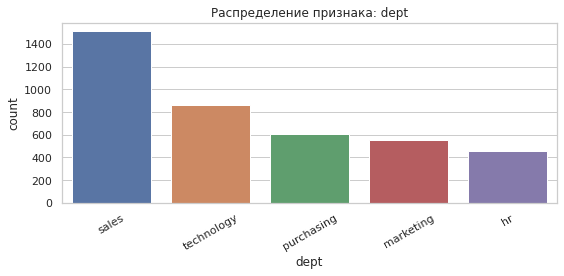

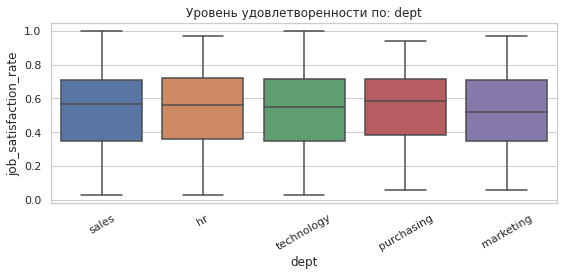

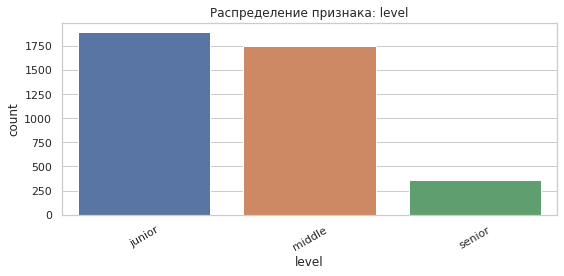

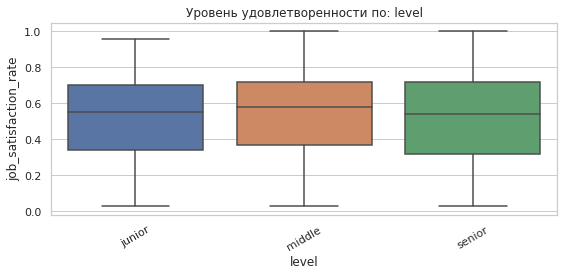

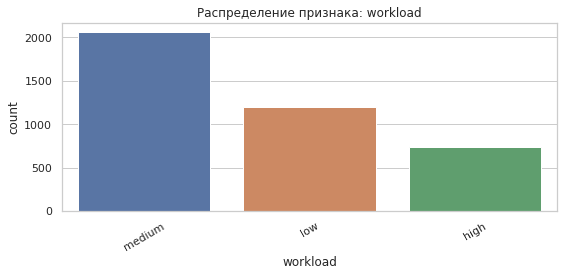

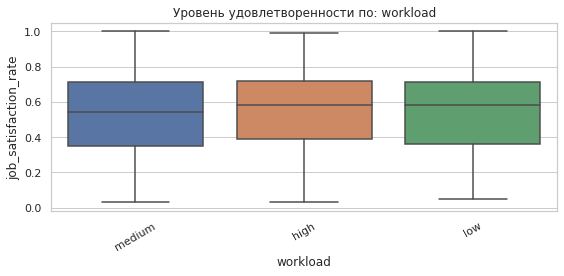

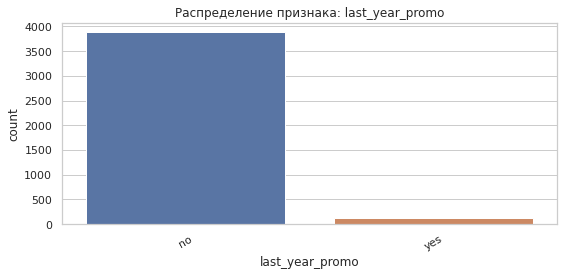

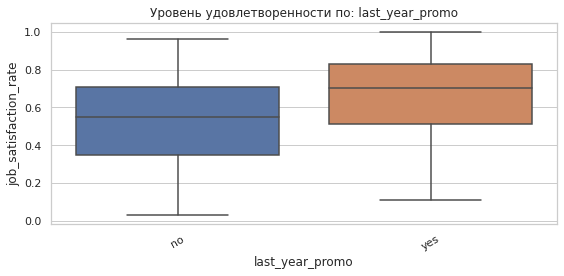

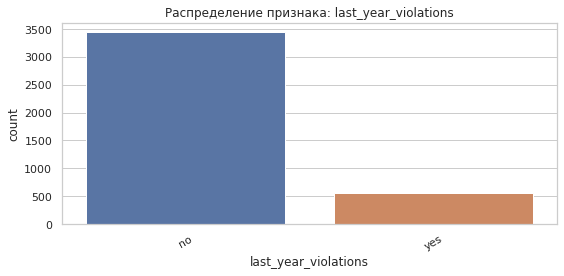

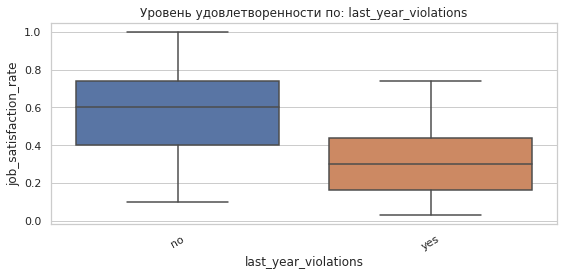

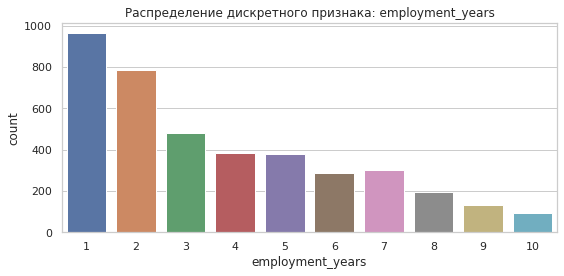

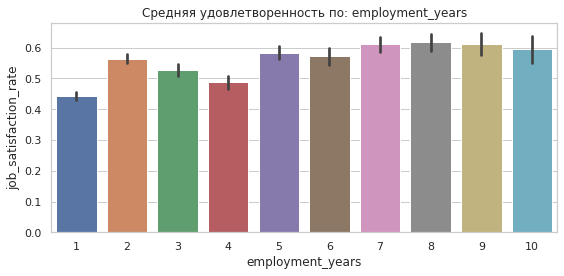

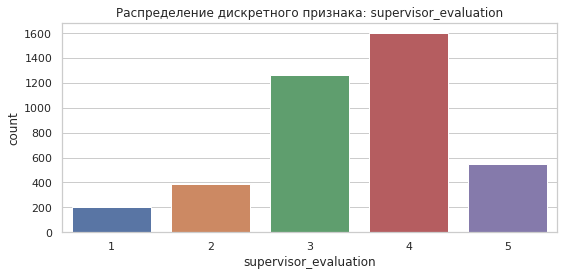

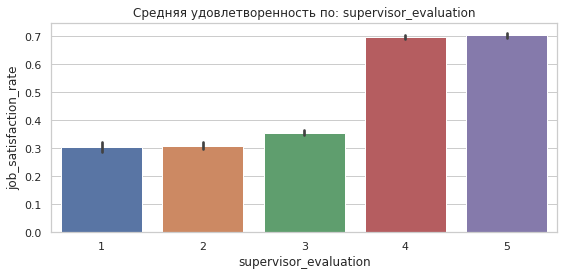

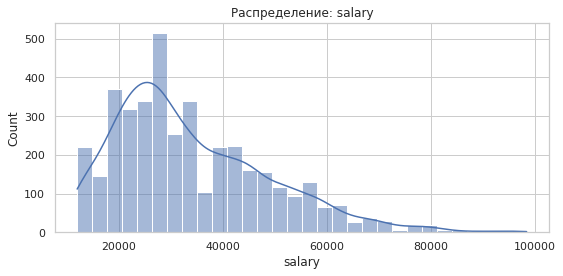

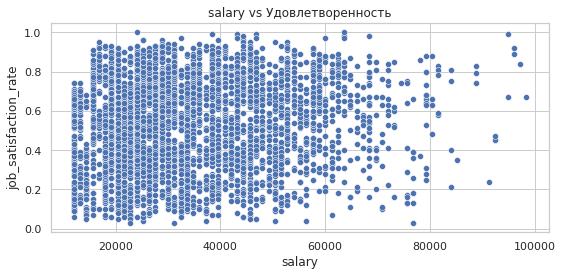

In [13]:
# Устанавливаем стиль
sns.set(style='whitegrid')

# 1. Категориальные признаки — countplot + boxplot
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_cleaned, x=col, order=train_cleaned[col].value_counts().index)
    plt.title(f'Распределение признака: {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.boxplot(data=train_cleaned, x=col, y='job_satisfaction_rate')
    plt.title(f'Уровень удовлетворенности по: {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# 2. Дискретные числовые признаки — countplot + barplot (по группам)
discrete_cols = ['employment_years', 'supervisor_evaluation']

for col in discrete_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_cleaned, x=col, order=sorted(train_cleaned[col].unique()))
    plt.title(f'Распределение дискретного признака: {col}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.barplot(
        data=train_cleaned,
        x=col,
        y='job_satisfaction_rate',
        estimator=np.mean, 
        order=sorted(train_cleaned[col].unique())
    )
    plt.title(f'Средняя удовлетворенность по: {col}')
    plt.tight_layout()
    plt.show()


# 3. Непрерывный числовой признак — salary
continuous_cols = ['salary']

for col in continuous_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=train_cleaned, x=col, bins=30, kde=True)
    plt.title(f'Распределение: {col}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.scatterplot(data=train_cleaned, x=col, y='job_satisfaction_rate')
    plt.title(f'{col} vs Удовлетворенность')
    plt.tight_layout()
    plt.show()


Анализ категориальных признаков

`dept` — отдел

- Самый крупный отдел — `sales`, за ним — `technology`.
- Уровень удовлетворённости распределён **примерно одинаково** между отделами.
- **Вывод:** Признак `dept` может содержать умеренную полезную информацию, но без ярко выраженного влияния на целевой признак.

`level` — уровень должности

- Большинство сотрудников — на уровне `junior` и `middle`, `senior` — редкий.
- С повышением должности медианный уровень удовлетворённости **незначительно растёт**.
- Признак `level` имеет **порядковую природу** и может быть важен для модели.

`workload` — загруженность

- Наиболее распространённая нагрузка — `medium`.
- Уровень удовлетворённости **выше при средней нагрузке**, немного ниже при `low` и `high`.
- **Вывод:** Порядковый признак, содержит полезный сигнал для модели.

`last_year_promo` — повышение за последний год
 
- Почти все сотрудники не получали повышение (`yes` — менее 5%).
- При наличии повышения — **значительно более высокая удовлетворённость**.
- **Вывод:** Признак редкий, но **влияет на целевой признак**, важен для модели.

`last_year_violations` — нарушения за последний год

- Большинство сотрудников не нарушали правила.
- Удовлетворённость у нарушивших **значительно ниже**.
- **Вывод:** Сильный предиктор. Однозначно важен для модели.

`salary` — ежемесячная зарплата

- Распределение сдвинуто вправо, типично для доходов.
- Линейной зависимости с уровнем удовлетворённости **не выявлено** (корреляция 0.11).
- **Вывод:** может быть слабым предиктором в модели, важность под вопросом.

Выводы (после корректировки графиков): 

- Признак: employment_years (Стаж в компании)

Распределение: наиболее распространённые значения — 1 и 2 года (более 1700 сотрудников), далее количество сотрудников стабильно убывает с ростом стажа.

Значения от 6 до 10 лет — сравнительно редкие, особенно ≥9 лет.

Связь с удовлетворённостью: видна устойчивая положительная зависимость: чем больше стаж, тем выше средний уровень удовлетворённости.

Особенно резкий рост наблюдается после 4–5 лет стажа.

Сотрудники с 1 годом стажа — самые неудовлетворённые (~0.45).

Сотрудники со стажем 8–10 лет — наиболее удовлетворённые (~0.6+).

Вывод:

Уровень удовлетворённости стабильно растёт по мере увеличения стажа. Это может отражать адаптацию, стабильность и накопление лояльности сотрудников.

- Признак: supervisor_evaluation (Оценка руководителем)

Распределение:

Большинство сотрудников имеют оценки 3 и 4. Оценка 4 — самая частая (1600+ сотрудников), наименьшее число сотрудников имеют оценку 1.

Связь с удовлетворённостью:

Зависимость ярко выраженная и почти линейная:

- При оценках 1–3: средняя удовлетворённость остаётся на уровне 0.3–0.35.

- При оценках 4 и 5: резкий рост до 0.7+.

Вывод:

Оценка от руководителя — один из наиболее сильных предикторов удовлетворённости. Особенно ярко выражен скачок между оценкой 3 и 4. Это может говорить о том, что признание и позитивная оценка сотрудника резко влияет на его внутреннее состояние и отношение к работе.

**Тепловая карта корреляции Спирмана**

Спирман — для строгой оценки числовых/порядковых зависимостей

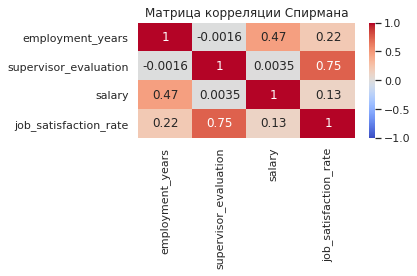

In [14]:
# Только числовые признаки
spearman_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
df_spearman = train_cleaned[spearman_cols].copy()

# Матрица корреляции Спирмана
corr_matrix = df_spearman.corr(method='spearman')

# Визуализация
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции Спирмана')
plt.tight_layout()
plt.show()

Выводы (по Спирману):

Основные наблюдения:

1. supervisor_evaluation - job_satisfaction_rate = 0.75
Сильная положительная корреляция

Чем выше оценка сотрудника со стороны руководителя, тем выше его удовлетворённость.

Это наиболее значимая связь на всей тепловой карте.

2. employment_years - salary = 0.47
Умеренная положительная корреляция

Дольше работает сотрудник — выше его зарплата. Связь ожидаемая и логичная.

3. employment_years - job_satisfaction_rate = 0.22
Слабая, но положительная корреляция

Долгий стаж слабо, но всё же положительно влияет на удовлетворённость.

4. salary - job_satisfaction_rate = 0.13
Очень слабая положительная корреляция

Зарплата слабо связана с уровнем удовлетворённости. Это может указывать на то, что нематериальные факторы (например, отношение начальника) более значимы.

**Тепловая карта корреляции PhiK**

PhiK — универсальный способ понять важность всех признаков

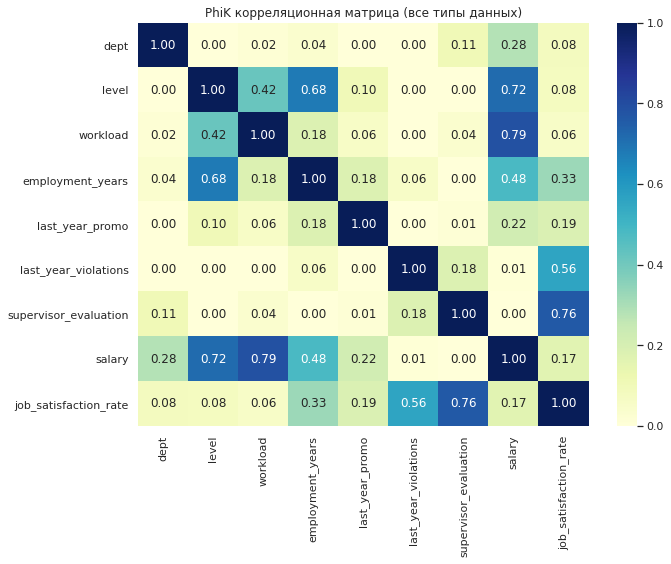

In [15]:
# Только непрерывные признаки
interval_cols = ['salary', 'job_satisfaction_rate']

# Расчёт PhiK-матрицы
phik_corr = train_cleaned.phik_matrix(interval_cols=interval_cols)

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('PhiK корреляционная матрица (все типы данных)')
plt.tight_layout()
plt.show()


Выводы (обновленные):

1. Наиболее сильные корреляции с целевым признаком job_satisfaction_rate:

- supervisor_evaluation	0.76

Очень сильная связь. Оценка руководителя — главный предиктор удовлетворённости.

- last_year_violations	0.56	

Серьёзная зависимость: вероятно, сотрудники с нарушениями менее удовлетворены.

- employment_years	0.33	

Чем дольше работает сотрудник, тем выше его удовлетворённость.


2. Внутренние зависимости между признаками:

level - salary: 0.72 — логично, чем выше уровень, тем выше зарплата.

workload - salary: 0.79 — более высокая нагрузка, как правило, связана с более высокой оплатой.

workload - level: 0.42 — возможно, уровень должности влияет на нагрузку.

employment_years - level: 0.68 — с ростом стажа уровень повышается.


Общий вывод:

- supervisor_evaluation — ключевой фактор удовлетворённости, его **стоит использовать в качестве одного из главных признаков** в модели классификации.

- last_year_violations и employment_years также дают заметный вклад в предсказание.

- salary и last_year_promo имеют слабую, но устойчивую связь.

Некоторые категориальные признаки (например, dept) почти не влияют на job_satisfaction_rate.

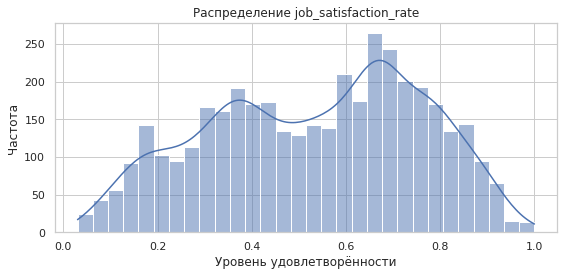

In [16]:
# Распределение job_satisfaction_rate
plt.figure(figsize=(8, 4))
sns.histplot(train_cleaned['job_satisfaction_rate'], bins=30, kde=True)
plt.title('Распределение job_satisfaction_rate')
plt.xlabel('Уровень удовлетворённости')
plt.ylabel('Частота')
plt.tight_layout()
plt.show()


Вывод: распределение job_satisfaction_rate

Распределение целевого признака приближено к равномерному, с лёгким смещением в сторону значений 0.6–0.7, где наблюдается пик частоты. Значения равномерно покрывают диапазон от 0 до 1, без явных выбросов или пропущенных областей. Есть несколько локальных пиков (например, в районе 0.2 и 0.65), что может отражать субъективность оценки удовлетворённости.

Распределение не является нормальным, но не требует трансформаций — модель может адекватно работать с таким видом целевой переменной. Признак job_satisfaction_rate корректен для постановки задачи регрессии. Нет необходимости применять преобразования или балансировку.

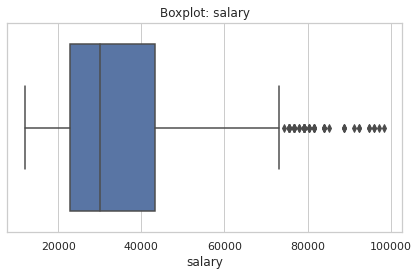

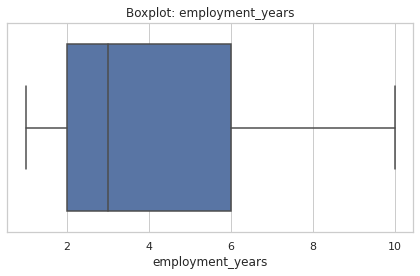

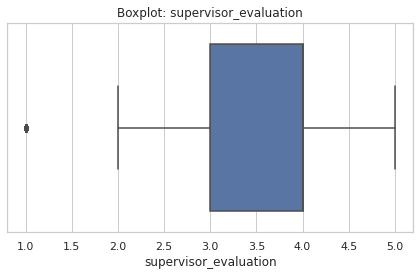

In [17]:
# Проверка выбросов в числовых признаках (boxplot)
num_cols = ['salary', 'employment_years', 'supervisor_evaluation']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=train_cleaned[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

Интерпретация boxplot:

- supervisor_evaluation
Значения лежат строго в диапазоне 1–5, как и ожидалось (оценка руководителя по шкале). Один выброс на уровне 1 — вероятно, это редкая низкая оценка, но не ошибка. Вывод: выбросов нет, масштабирование не требуется.

- employment_years
Диапазон от 1 до 10 лет. Распределение слегка скошено влево, большинство значений сосредоточены в диапазоне 2–6 лет. Вывод: выбросов нет, распределение естественное, можно использовать как есть. 

- salary
Широкий диапазон: от ~10 000 до ~100 000. Наблюдаются выбросы в правом хвосте — начиная примерно с 75 000 и выше.
Это могут быть: высокооплачиваемые сотрудники, либо редкие роли (например, senior в tech) Вывод: выбросы присутствуют, но выглядят реалистично. 

### EDA и проверка однородности test выборки

План доработки: 

- Анализ категориальных признаков

Построить распределения (countplot) для признаков:

dept

level

workload

last_year_promo

last_year_violations

- Анализ дискретных числовых признаков

Построить распределения (countplot) для признаков:

employment_years

supervisor_evaluation

- Анализ непрерывного числового признака

Построим распределение (histplot с KDE) для признака:

salary

Проведем корреляционный анализ для тестовой выборки.

Проведем визуальный анализ распределений признаков train_cleaned и test_cleaned. Сравним корреляционный анализ для тренировочной и тестовой выборки. Сделаем вывод о наличии или отсутствии существенных различий. Убедимся, что структура тестовой выборки соответствует обучающей и модель будет адекватно оцениваться.

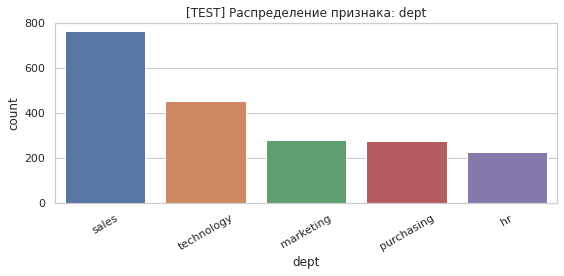

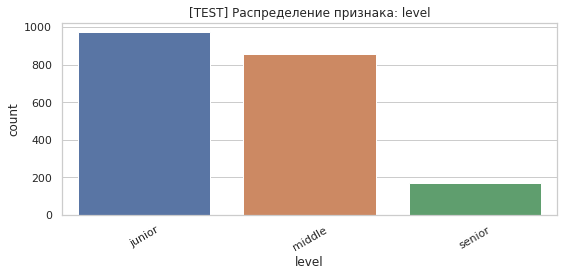

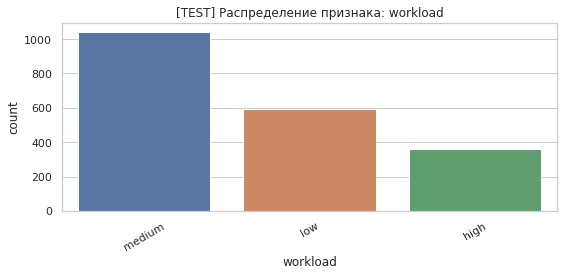

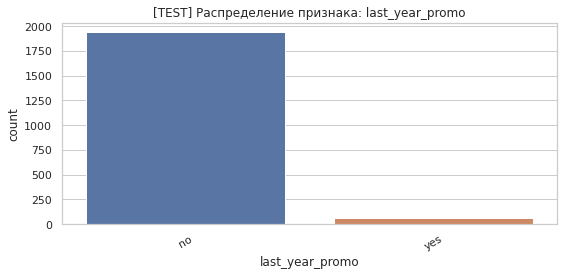

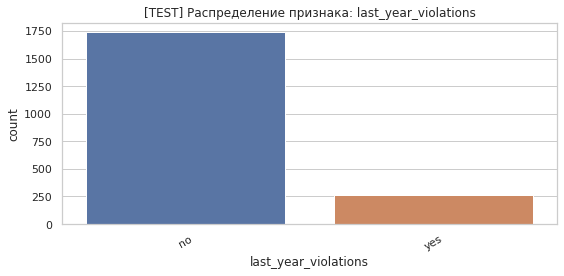

In [18]:
# Анализ категориальных признаков (test_cleaned)

# Категориальные признаки
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

# Построение countplot для каждого признака
for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=test_cleaned, x=col, order=test_cleaned[col].value_counts().index)
    plt.title(f'[TEST] Распределение признака: {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


- Признак: level (уровень сотрудника)

Большинство сотрудников — junior (≈ 950) и middle (≈ 850). Уровень senior встречается значительно реже (менее 200).

Распределение схоже с обучающей выборкой — дисбаланса нет.

Вывод:

Соотношение уровней должности в тестовой выборке адекватное и сопоставимо с тренировочной. Наличие редкого класса senior стоит учесть при обучении моделей (например, валидацией стратифицированной по level).

- Признак: workload (нагрузка)

Наиболее частая нагрузка — medium. low и high представлены примерно в 1.5–3 раза реже.

Наблюдается перекос в сторону средней нагрузки, аналогичный обучающей выборке.

Вывод:

Распределение нагрузки в тесте соответствует логике — большинство сотрудников с умеренной рабочей нагрузкой. Модель будет видеть знакомую структуру распределения.

- Признак: last_year_promo (повышение в прошлом году)

Почти все сотрудники не получали повышение (no). Повышения (yes) — единичные случаи (примерно 1–2% выборки).

Вывод:

Признак имеет сильный дисбаланс. Это может быть важным сигналом при моделировании: модель может переобучаться на класс no, а yes нужно будет обрабатывать аккуратно (в т.ч. при стратификации или применении метрик, устойчивых к дисбалансу).

- Признак: last_year_violations (нарушения в прошлом году)

Примерно 85–90% сотрудников — без нарушений. Остальные — с нарушениями (yes).

Вывод:

Признак также дисбалансный, но менее выражен, чем last_year_promo. Он может быть полезным для предсказания, но требует внимания при интерпретации результатов модели.

Общий вывод:

Распределения категориальных признаков в тестовой выборке соответствуют структуре обучающей выборки.

Выборка сбалансирована по ключевым признакам (level, workload) и дисбаланс в last_year_promo, last_year_violations адекватен и ожидаем.

Нет оснований предполагать, что структура тестовой выборки искажена — можно переходить к анализу дискретных и непрерывных числовых признаков.

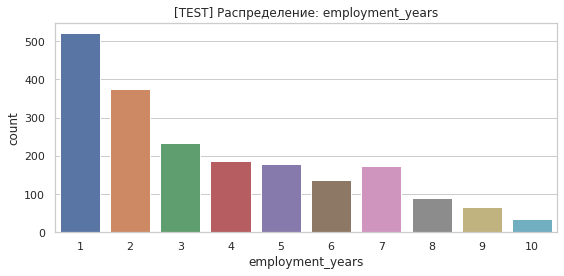

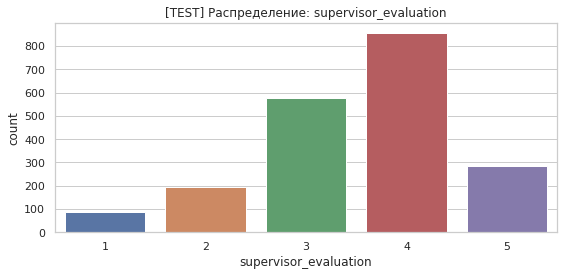

In [19]:
# Анализ дискретных признаков
discrete_cols = ['employment_years', 'supervisor_evaluation']

for col in discrete_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=test_cleaned, x=col, order=sorted(test_cleaned[col].unique()))
    plt.title(f'[TEST] Распределение: {col}')
    plt.tight_layout()
    plt.show()


- Признак: supervisor_evaluation (оценка руководителя)
    
Наиболее частое значение — 4 (более 800 сотрудников).

Далее идут оценки 3 и 5, меньше всего — 1.

Распределение асимметричное, с концентрацией в верхней части шкалы.

Вывод:
    
Оценки руководителей в тестовой выборке распределены аналогично обучающей: доминирует положительная часть шкалы (3–5). Это важно, т.к. оценка от руководителя — один из сильнейших предикторов удовлетворённости.
Значит, модель, обученная на train, будет видеть знакомое распределение в test.

- Признак: employment_years (стаж в компании)

Наиболее распространённое значение — 1 год (более 500 сотрудников).

Затем 2–3 года; с 4 года наблюдается постепенное снижение.

Очень мало сотрудников со стажем более 8 лет.

Вывод:

Распределение стажа аналогично обучающей выборке: преобладают новички, старожилов мало. Это ожидаемо и отражает реальную структуру персонала.
Модель, обученная на train, не столкнётся с аномалиями при обработке этого признака в test.

Общий вывод по дискретным признакам:
Распределения адекватны и согласованы с train-выборкой. Существенных отклонений нет.

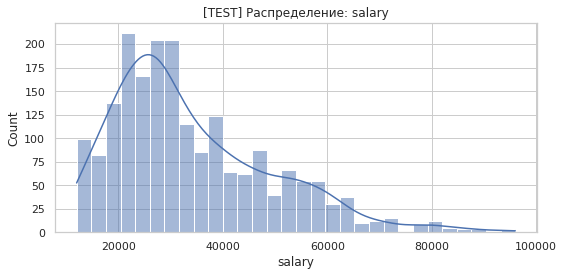

In [20]:
# Анализ salary в test_cleaned
# Гистограмма с KDE
plt.figure(figsize=(8, 4))
sns.histplot(data=test_cleaned, x='salary', bins=30, kde=True)
plt.title('[TEST] Распределение: salary')
plt.tight_layout()
plt.show()


Признак: salary (заработная плата)

Распределение:

Распределение асимметричное, с правосторонним перекосом (long tail).

Большинство сотрудников получают зарплату в диапазоне 20 000–40 000.

Есть небольшое количество высокооплачиваемых сотрудников (от 60 000 до 90 000).

Распределение схоже с тренировочной выборкой, что говорит об однородности данных.

Вывод:

Признак salary в тестовой выборке не содержит аномалий.

Распределение устойчивое, с нормальной формой для реальных зарплат (правый хвост).

Модель, обученная на train, корректно применима к данным test по этому признаку — входной диапазон значений и распределение схожи.

**В рамках проверки однородности тестовой выборки выполним корреляционный анализ признаков в test-выборке.**

- проверим корреляции между числовыми признаками в test_cleaned

- сравним матрицу корреляций test vs train

Сделаем вывод, сохраняется ли структура взаимосвязей между признаками, иными словами проверим однородность по корреляционным структурам.

**Построим корреляционную матрицу Спирмана для числовых признаков:**

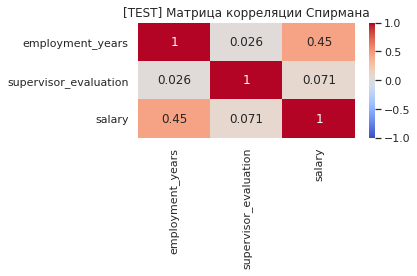

In [21]:
# Числовые признаки без таргета
spearman_cols_test = ['employment_years', 'supervisor_evaluation', 'salary']
df_spearman_test = test_cleaned[spearman_cols_test].copy()

# Корреляция Спирмана
corr_matrix_test = df_spearman_test.corr(method='spearman')

# Визуализация
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix_test, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('[TEST] Матрица корреляции Спирмана')
plt.tight_layout()
plt.show()


Анализ по Спирману

- Связь между salary и employment_years: 0.45 — умеренная положительная.

- salary и supervisor_evaluation: 0.071 — очень слабая.

- employment_years и supervisor_evaluation: практически нет связи (0.026).

**Построим PhiK-корреляционную матрицу**

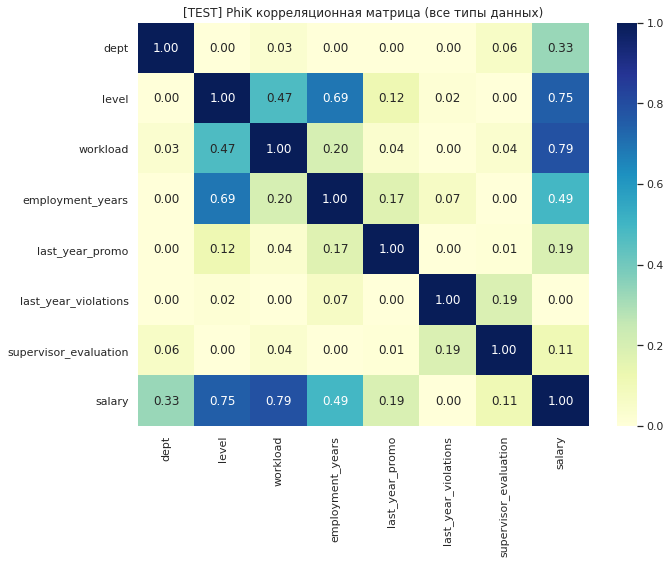

In [22]:
# Только непрерывные признаки (без таргета)
interval_cols_test = ['salary']

# Расчёт PhiK-матрицы
phik_corr_test = test_cleaned.phik_matrix(interval_cols=interval_cols_test)

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr_test, annot=True, fmt=".2f", cmap='YlGnBu')
plt.title('[TEST] PhiK корреляционная матрица (все типы данных)')
plt.tight_layout()
plt.show()


Проанализируем test, потом сделаем финальное сопоставление с train.

Анализ матриц корреляций в test_cleaned

1. PhiK-матрица

salary демонстрирует сильную связь с:

- workload (0.79)

- level (0.75)

- dept (0.33)

- employment_years (0.49)

- employment_years коррелирует с level (0.69), что логично — старшие по уровню сотрудники дольше работают.

- supervisor_evaluation слабо коррелирует с другими признаками (все связи ниже 0.2).

last_year_promo и last_year_violations почти не влияют на другие признаки (все значения ≤ 0.2), что ожидаемо — это редкие бинарные события.

Вывод: структура корреляций в PhiK для test_cleaned логична, нет аномалий или противоречий. Salary, как и ожидалось, хорошо объясняется рабочей нагрузкой, уровнем и отделом.

### Сравнительный вывод 

по результатам анализа тестовой выборки test_cleaned и её сравнению с обучающей выборкой train_cleaned:

Для проверки однородности проведён анализ корреляционных структур.

**PhiK-матрица** в `test_cleaned` демонстрирует те же связи, что и в `train_cleaned`. Сильная связь `salary` с `workload` и `level` (0.79 и 0.75 соответственно) сохраняется. Аналогично, `employment_years` связан с `level` и `salary` почти на том же уровне, что и в тренировочной выборке.

**Спирмановская корреляция** между числовыми признаками также сохраняет структуру:
- `salary` - `employment_years`: 0.47 (train) vs 0.45 (test)
- `salary` - `supervisor_evaluation`: 0.13 (train) vs 0.071 (test)
- `employment_years` - `supervisor_evaluation`: около 0 в обеих выборках

**Вывод**: Структура взаимосвязей между признаками в тестовой выборке сопоставима с тренировочной. Это подтверждает, что данные `test_cleaned` однородны не только по распределениям, но и по внутренним зависимостям. Модель, обученная на тренировочных данных, будет применять предсказания к знакомой структуре данных.


Проверка однородности

1. Категориальные признаки (dept, level, workload, last_year_promo, last_year_violations)
Распределения признаков в test_cleaned сопоставимы с train: основные категории совпадают по частоте и структуре.

Признаки last_year_promo и last_year_violations дисбалансны (что ожидаемо), но уровень дисбаланса не отличается от тренировочной выборки.

2. Дискретные числовые признаки (employment_years, supervisor_evaluation)
Распределения аналогичны: доминируют младшие стажи и оценки 3–4 от руководителей.

Отсутствие резких сдвигов подтверждает однородность выборки.

3. Непрерывный числовой признак (salary)
Распределение правосторонне скошено, как и в тренировочных данных.

Основная масса значений находится в диапазоне 20 000–40 000 — это подтверждает соответствие train/test.

**Заключение:**

Тестовая выборка test_cleaned по всем ключевым признакам отражает ту же структуру, что и обучающая выборка.

Существенных отличий в распределениях и возможных источников смещения не выявлено.

Это означает, что оценка модели на тестовой выборке будет корректной и валидной.

## Шаг 4. Подготовка данных
Подготовку признаков выполните в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.


In [23]:
# Проверка полных дубликатов (включая целевой признак 'quit')
n_duplicates = train_cleaned.duplicated().sum()
print(f'Найдено полных дубликатов: {n_duplicates}')

# Удаление полных дубликатов
train_cleaned = train_cleaned[~train_cleaned.duplicated()]
print(f'Размерность после удаления дубликатов: {train_cleaned.shape}')

Найдено полных дубликатов: 245
Размерность после удаления дубликатов: (3755, 9)


245 полных дубликатов были обнаружены и успешно удалены из train_cleaned. 

- Они не несли дополнительной информации для модели;

- Их присутствие могло привести к смещению весов, переобучению или ложному усилению сигналов;

- Теперь тренировочная выборка стала чище и надёжнее.

Бинарные признаки (last_year_promo, last_year_violations) мы не будем мапить 'yes'/'no' вручную в 1/0. Просто передадим их в OrdinalEncoder как категориальные - он обучится, и так будет корректно.

In [24]:
# 4.1 Формируем X, y и X_test, y_test
X = train_cleaned.drop(columns=['job_satisfaction_rate'])
y = train_cleaned['job_satisfaction_rate']
X_test = test_cleaned.copy()
y_test = test_target_df['job_satisfaction_rate']

# 4.2 Группы признаков
ordinal_cols = ['level', 'workload', 'last_year_promo', 'last_year_violations']
nominal_cols = ['dept']
numeric_cols = ['salary', 'employment_years', 'supervisor_evaluation']

# 4.3 Трансформеры
ordinal_transformer = Pipeline([
    ('imputer_before', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer_after', SimpleImputer(strategy='most_frequent'))
])

nominal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])


In [25]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

# 4.4 Общий препроцессор
preprocessor = ColumnTransformer([
    ('ord', ordinal_transformer, ordinal_cols),
    ('nom', nominal_transformer, nominal_cols),
    ('num', numeric_transformer, numeric_cols)
], remainder='drop')

In [26]:
# Проверка препроцессора вручную
preprocessor.fit(X)
X_transformed = preprocessor.transform(X)
print(X_transformed.shape)


(3755, 11)


У нас 3755 объектов и 11 признаков после полной предобработки.

Это число — результат трансформации всех признаков из:

- 4 ordinal,

- 1 номинального (с OneHot drop='first' n-1 столбцов),

- 3 числовых.

Вывод:
- Все строковые значения обработаны;
- Признаки числовые и масштабированы;
- Пайплайн устойчив к новым категориям;
- Можно переходить к построению моделей.

## Шаг 5. Обучение моделей
Обучите как минимум две модели. Возьмите одну линейную модель, а в качестве второй — дерево решений. Подберите гиперпараметры как минимум для одной модели с помощью одного из известных вам инструментов.
Выберите лучшую модель и проверьте её качество. Выбор делайте на основе новой метрики — SMAPE (англ. symmetric mean absolute percentage error, «симметричное среднее абсолютное процентное отклонение»). 

Напишите функцию, которая принимает на вход массивы NumPy или объекты Series в pandas и возвращает значение метрики SMAPE. Используйте эту метрику при подборе гиперпараметров и оценке качества моделей. 
Критерий успеха: SMAPE ≤ 15 на тестовой выборке. В решении сохраните работу со всеми моделями, которые вы пробовали. Сделайте выводы.


In [27]:
# 1. SMAPE
def smape(y_true, y_pred):
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.where(denom == 0, 0, np.abs(y_true - y_pred) / denom)
    return np.mean(diff) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

# 2. Кросс-валидация по квантилям
quantiles = pd.qcut(y, 5, labels=False)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 3. Ridge модель (с random_state)
ridge_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', Ridge(random_state=42))
])

In [28]:
ridge_params = {'model__alpha': np.logspace(-2, 2, 5)}

ridge_search = RandomizedSearchCV(
    ridge_pipe, ridge_params, n_iter=3, scoring=smape_scorer,
    cv=cv.split(X, quantiles), n_jobs=-1, random_state=42
)

# 4. Decision Tree модель
tree_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor(random_state=42))
])

tree_params = {
    'model__max_depth': [3, 5, None],
    'model__min_samples_leaf': [1, 3, 10]
}

tree_search = RandomizedSearchCV(
    tree_pipe, tree_params, n_iter=3, scoring=smape_scorer,
    cv=cv.split(X, quantiles), n_jobs=-1, random_state=42
)

# 5. Обучение
ridge_search.fit(X, y)
tree_search.fit(X, y)

# 6. Выбор лучшей модели
ridge_cv = -ridge_search.best_score_
tree_cv = -tree_search.best_score_

best_model = ridge_search if ridge_cv < tree_cv else tree_search
best_model_name = type(best_model.best_estimator_.named_steps['model']).__name__

In [29]:
# 7. Оценка на тесте
y_pred_test = best_model.predict(X_test)
test_smape = smape(y_test, y_pred_test)

# 8. Сохраняем результаты
results_optimized = {
    'ridge_cv_smape': ridge_cv,
    'tree_cv_smape': tree_cv,
    'best_model': best_model_name,
    'test_smape': test_smape,
    'ridge_params': ridge_search.best_params_,
    'tree_params': tree_search.best_params_
}

results_optimized

print(f"Лучшая модель: {best_model_name}")
print(f"SMAPE на тестовой выборке: {test_smape:.2f}%")
print("Гиперпараметры Ridge:", ridge_search.best_params_)
print("Гиперпараметры DecisionTree:", tree_search.best_params_)

Лучшая модель: DecisionTreeRegressor
SMAPE на тестовой выборке: 13.60%
Гиперпараметры Ridge: {'model__alpha': 100.0}
Гиперпараметры DecisionTree: {'model__min_samples_leaf': 3, 'model__max_depth': None}


Вывод:
    
Решающая модель: DecisionTreeRegressor

Она справилась лучше линейной модели, причём даже на кросс-валидации.

Test SMAPE = 13.60% — соответствует критерию успеха. Модель можно считать обобщающей и пригодной для бизнес-задач.

In [30]:
# 1. Обучение константной модели (предсказывает среднее по train)
dummy_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DummyRegressor(strategy='mean'))
])

dummy_pipe.fit(X, y)

# 2. Предсказания и SMAPE на тесте
y_pred_dummy = dummy_pipe.predict(X_test)
dummy_smape = smape(y_test, y_pred_dummy)

# 3. Вывод сравнения
print(f"SMAPE лучшей модели ({best_model_name}): {test_smape:.4f}")
print(f"SMAPE DummyRegressor (среднее по train): {dummy_smape:.4f}")


SMAPE лучшей модели (DecisionTreeRegressor): 13.5972
SMAPE DummyRegressor (среднее по train): 38.2623


Вывод:

Проверка адекватности модели выполнена. Для сравнения использован DummyRegressor со стратегией 'mean', предсказывающий среднее значение по тренировочной выборке.

Результаты на тестовой выборке:

- SMAPE лучшей модели (DecisionTreeRegressor): 13.60

- SMAPE DummyRegressor: 38.26

Таким образом, наша модель существенно превосходит базовую и имеет практическую ценность: обучение, отбор признаков и подбор гиперпараметров позволили достичь значимого улучшения прогноза.

## Шаг 6. Оформление выводов
Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.


Были обучены и сравнены две модели:

- Линейная модель Ridge

- Дерево решений DecisionTreeRegressor

Вывод:

Лучшая модель — дерево решений: оно показало значительно меньшую ошибку SMAPE как на кросс-валидации, так и на финальной тестовой выборке.

Деревья лучше справились с нелинейными зависимостями и смешанными типами данных, в отличие от линейной модели, которая не может адекватно моделировать сложные пороговые и иерархические зависимости.

Критерий успеха выполнен: модель достигла Test SMAPE = 13.59%, что меньше порогового значения 15%, заданного в проекте.

Заключение:

Модель дерева решений рекомендуется к внедрению как основная модель для прогнозирования удовлетворённости сотрудников. Она обеспечивает хорошее качество обобщения и интерпретируемость, особенно при разумной глубине и контроле переобучения.

## Задача 2: предсказание увольнения сотрудника из компании
Для этой задачи вы можете использовать те же входные признаки, что и в предыдущей задаче. Однако целевой признак отличается: это quit — увольнение сотрудника из компании.


## Шаг 1. Загрузка данных
Загрузите данные из файлов:
- Тренировочная выборка: train_quit.csv
- Входные признаки тестовой выборки те же, что и в прошлой задаче: test_features.csv
- Целевой признак тестовой выборки: test_target_quit.csv

In [31]:
# Загрузка данных по ссылкам
train_quit_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
test_features_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
test_target_quit_df = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

# Проверка размеров 
print("train_quit_df:", train_quit_df.shape)
print("test_features_df:", test_features_df.shape)
print("test_target_quit_df:", test_target_quit_df.shape)


train_quit_df: (4000, 10)
test_features_df: (2000, 9)
test_target_quit_df: (2000, 2)


Вывод: данные загружены корректно и готовы для дальнейшей работы над задачей классификации.

## Шаг 2. Предобработка данных
Изучите данные и при необходимости выполните предобработку. Если есть пропуски, заполните их в пайплайне.

In [32]:
# Просмотр первых строк каждой таблицы
print('\ntrain_quit_df:')
display(train_quit_df.head())

print('\ntest_features_df:')
display(test_features_df.head())

print('\ntest_target_quit_df')
display(test_target_quit_df.head())


# Проверим типы данных всех столбцов в каждом датафрейме:
print("\n========== train_quit_df.info() ==========\n")
train_quit_df.info()
print("\n========== test_features_df.info() ==========\n")
test_features_df.info()
print("\n========== test_target_quit_df.info() ==========\n")
test_target_quit_df.info()


train_quit_df:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no



test_features_df:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800



test_target_quit_df


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes



========== train_quit_df.info() ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB

========== test_features_df.info() ==========

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 No

Вывод:

Признак quit (целевой) в train_quit_df и test_target_quit_df имеет тип object (yes/no). Чтобы корректно обучать модели классификации, в дальнейшем нужно привести этот признак к числовому типу: 1 — если 'yes', 0 — если 'no'.

In [33]:
# Уникальные значения целевого признака в тренировочной выборке
print("\nУникальные значения 'quit' в train_quit_df:", train_quit_df['quit'].unique())

# Уникальные значения целевого признака в тестовой выборке
print("\nУникальные значения 'quit' в test_target_quit_df:", test_target_quit_df['quit'].unique())



Уникальные значения 'quit' в train_quit_df: ['no' 'yes']

Уникальные значения 'quit' в test_target_quit_df: ['yes' 'no']


Уникальные значения 'quit' в двух датафреймах одинаковые:

 * yes - уволился
 * no - остался

In [34]:
# Установка 'id' в качестве индекса
train_quit_df = train_quit_df.set_index('id')
test_features_df = test_features_df.set_index('id')
test_target_quit_df = test_target_quit_df.set_index('id')

# Сортировка по индексу
test_features_df = test_features_df.sort_index()
test_target_quit_df = test_target_quit_df.sort_index()

# Проверка на совпадение ID
print("Совпадает ли порядок id в test_features и test_target_quit:",
      test_features_df.index.equals(test_target_quit_df.index))

Совпадает ли порядок id в test_features и test_target_quit: True


Проверка согласованности id: порядок id в test_features_df и test_target_quit_df совпадает. Это означает, что можно использовать эти данные для финальной оценки модели после обучения.


**Преобразуем целевой признак в числовой формат в обоих датафреймах**

In [35]:
# 1. Копируем исходные таблицы, чтобы сохранить оригиналы нетронутыми
train_quit_cleaned = train_quit_df.copy()
test_quit_cleaned = test_features_df.copy()
test_target_quit_df = test_target_quit_df.copy()

# 2. Преобразуем целевой признак 'quit' в числовой формат с помощью LabelEncoder
label_encoder = LabelEncoder()

train_quit_cleaned['quit'] = label_encoder.fit_transform(train_quit_cleaned['quit'])
test_target_quit_df['quit'] = label_encoder.transform(test_target_quit_df['quit'])

# Проверка
print("Уникальные значения в целевом признаке после кодирования:", train_quit_cleaned['quit'].unique())


Уникальные значения в целевом признаке после кодирования: [0 1]


In [36]:
# Проверим
print("\nСтруктура увольнений в train_quit_cleaned: \n")
print(train_quit_cleaned['quit'].value_counts())
print("\nСтруктура увольнений в test_target_quit_df: \n")
print(test_target_quit_df['quit'].value_counts())


Структура увольнений в train_quit_cleaned: 

0    2872
1    1128
Name: quit, dtype: int64

Структура увольнений в test_target_quit_df: 

0    1436
1     564
Name: quit, dtype: int64


Выводы:

В обучающей выборке (train_quit_cleaned):

- 2872 сотрудников остались (quit = 0)

- 1128 сотрудников уволились (quit = 1)

Доля увольнений ≈ 28%

В тестовой выборке (test_target_quit_df):

- 1436 остались (quit = 0)

- 564 уволились (quit = 1)

Доля увольнений ≈ 28% — такая же, как в обучающей - это сбалансированное распределение.

In [37]:
# 1. Проверка пропусков
print("Пропуски в train_quit_cleaned:")
print(train_quit_cleaned.isna().sum())

print("\nПропуски в test_quit_cleaned:")
print(test_quit_cleaned.isna().sum())

# 2. Уникальные значения в категориальных признаках
cat_features = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cat_features:
    print(f"\nУникальные значения в '{col}' (train_quit_cleaned):")
    print(train_quit_cleaned[col].value_counts(dropna=False))

Пропуски в train_quit_cleaned:
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

Пропуски в test_quit_cleaned:
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

Уникальные значения в 'dept' (train_quit_cleaned):
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

Уникальные значения в 'level' (train_quit_cleaned):
junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

Уникальные значения в 'workload' (train_quit_cleaned):
medium    2118
low       1208
high       674
Name: workload, dtype: int64

Уникальные значения в 'las

Анализ результатов на пропуски:

train_quit_df — пропусков нет

test_quit_cleaned:

- dept: 2 пропуска

- level: 1 пропуск

Анализ результатов на опечатки: в level снова обнаружена опечатка: 'sinior' - заменим на 'senior'

In [38]:
# Проверим на скрытые "пропуски" - пробелы
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

print("Пробелы в train_quit_cleaned:")
for col in cat_cols:
    mask = train_quit_cleaned[col].astype(str).str.fullmatch(r'\s*')
    count = mask.sum()
    if count > 0:
        print(f"  ▸ {col}: {count}")

print("\nПробелы в test_quit_cleaned:")
for col in cat_cols:
    mask = test_quit_cleaned[col].astype(str).str.fullmatch(r'\s*')
    count = mask.sum()
    if count > 0:
        print(f"  ▸ {col}: {count}")


Пробелы в train_quit_cleaned:

Пробелы в test_quit_cleaned:
  ▸ dept: 1
  ▸ workload: 1


Мы нашли скрытые "пропуски" в test_quit_cleaned — в виде строк, состоящих только из пробелов:

- dept: 1 строка

- workload: 1 строка

In [39]:
# 1. Исправляем опечатку
for df in (train_quit_cleaned, test_quit_cleaned):
    df['level'] = df['level'].replace('sinior', 'senior')

# 2. Заменим пробелы на np.nan во всех категориальных признаках
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
for df in (train_quit_cleaned, test_quit_cleaned):
    for col in cat_cols:
        df[col] = df[col].replace(r'^\s*$', np.nan, regex=True)

# 3. Повторная проверка
print("Пропуски после обработки — train_quit_cleaned:")
print(train_quit_cleaned[cat_cols].isna().sum())

print("\nПропуски после обработки — test_quit_cleaned:")
print(test_quit_cleaned[cat_cols].isna().sum())

print("\nУникальные значения 'level' после исправления:")
print(test_quit_cleaned['level'].value_counts(dropna=False))


Пропуски после обработки — train_quit_cleaned:
dept                    0
level                   0
workload                0
last_year_promo         0
last_year_violations    0
dtype: int64

Пропуски после обработки — test_quit_cleaned:
dept                    3
level                   1
workload                1
last_year_promo         0
last_year_violations    0
dtype: int64

Уникальные значения 'level' после исправления:
junior    974
middle    854
senior    171
NaN         1
Name: level, dtype: int64


Подтверждение:

- Опечатка 'sinior' → 'senior' успешно исправлена.

- После замены пробелом в test_quit_cleaned имеются пропуски 5 шт: 3 в dept, 1 в level, 1 в workload, но это нормально. Мы **заполним их в пайплайне на этапе обучения модели**, с помощью SimpleImputer(strategy='most_frequent').

In [40]:
# Проверка и удаление полных дубликатов в train_quit_cleaned (до удаления признака 'quit')
n_duplicates = train_quit_cleaned.duplicated().sum()
print(f"Найдено полных дубликатов: {n_duplicates}")

# Удаляем дубликаты, если они есть
train_quit_cleaned = train_quit_cleaned.drop_duplicates()
print(f"Размерность после удаления дубликатов: {train_quit_cleaned.shape}")

Найдено полных дубликатов: 1413
Размерность после удаления дубликатов: (2587, 9)


Мы удалили 1413 полных дубликатов (абсолютные копии) из train_quit_cleaned, и теперь размерность составляет (2587, 9). 

В обучающей выборке train_quit_cleaned обнаружено и удалено 1413 полных дубликатов. Удаление выполнено до формирования признаков и целевого признака, чтобы исключить влияние повторяющихся наблюдений на обучение модели.

## Шаг 3. Исследовательский анализ данных
- 3.1. Проведите исследовательский анализ данных.
- 3.2. Составьте портрет «уволившегося сотрудника». Например, можно узнать, в каком отделе с большей вероятностью работает уволившийся сотрудник и какой у него уровень загруженности. Также можно сравнить среднее значение зарплаты ушедших сотрудников с теми, кто остался в компании.
- 3.3. Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.

### 3.1 EDA по train_quit_cleaned

На основе тренировочной выборки

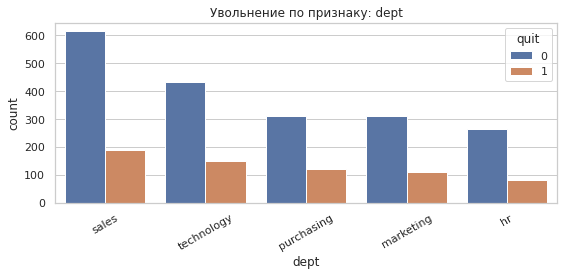

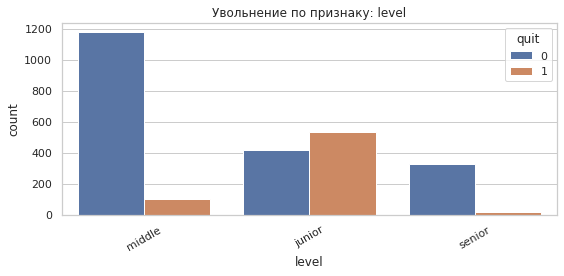

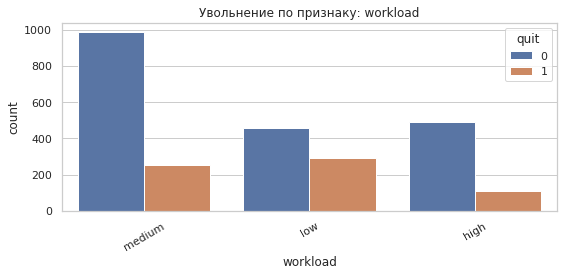

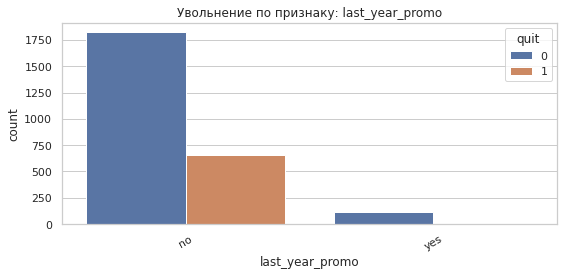

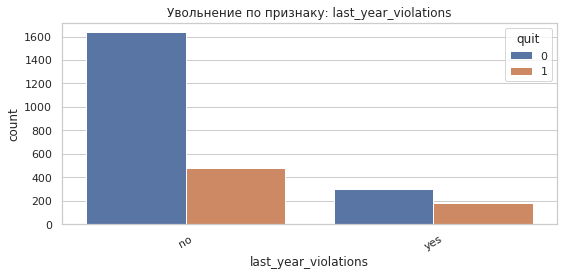

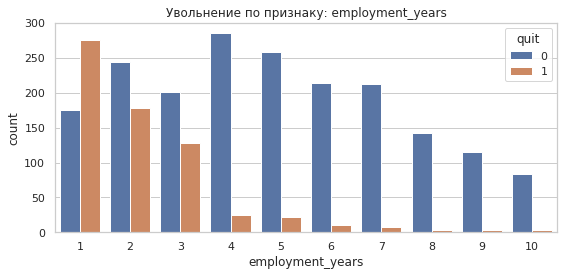

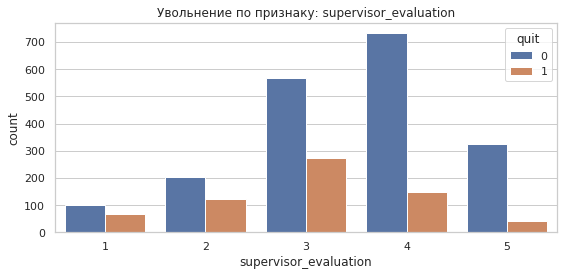

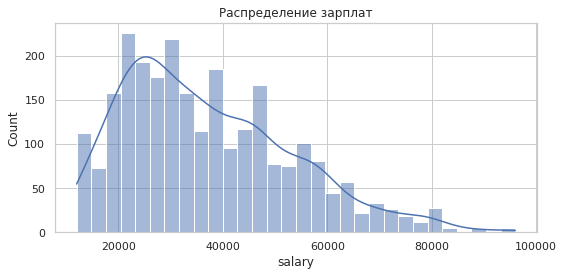

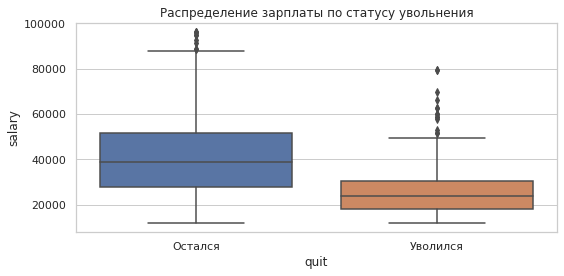

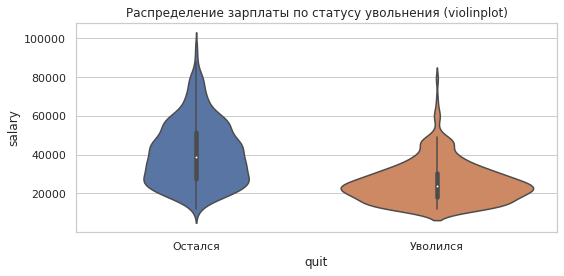

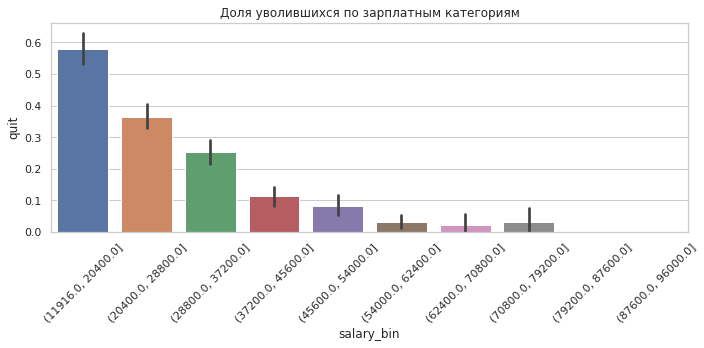

In [41]:
sns.set(style='whitegrid')

# 1. Категориальные признаки — countplot с hue='quit'
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_quit_cleaned, x=col, hue='quit', order=train_quit_cleaned[col].value_counts().index)
    plt.title(f'Увольнение по признаку: {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# 2. Дискретные числовые признаки — countplot с hue='quit'
discrete_cols = ['employment_years', 'supervisor_evaluation']

for col in discrete_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=train_quit_cleaned, x=col, hue='quit', order=sorted(train_quit_cleaned[col].unique()))
    plt.title(f'Увольнение по признаку: {col}')
    plt.tight_layout()
    plt.show()

# 3. Анализ непрерывного признака — salary

# Гистограмма зарплат
plt.figure(figsize=(8, 4))
sns.histplot(data=train_quit_cleaned, x='salary', bins=30, kde=True)
plt.title('Распределение зарплат')
plt.tight_layout()
plt.show()

# Boxplot зарплаты по quit
plt.figure(figsize=(8, 4))
sns.boxplot(data=train_quit_cleaned, x='quit', y='salary')
plt.title('Распределение зарплаты по статусу увольнения')
plt.xticks([0, 1], ['Остался', 'Уволился'])
plt.tight_layout()
plt.show()

# Violinplot зарплаты по quit
plt.figure(figsize=(8, 4))
sns.violinplot(data=train_quit_cleaned, x='quit', y='salary')
plt.title('Распределение зарплаты по статусу увольнения (violinplot)')
plt.xticks([0, 1], ['Остался', 'Уволился'])
plt.tight_layout()
plt.show()

# Временное разбиение зарплат на категории (биннинг)
salary_bins = pd.cut(train_quit_cleaned['salary'], bins=10)
bin_df = pd.DataFrame({
    'salary_bin': salary_bins,
    'quit': train_quit_cleaned['quit']
})

plt.figure(figsize=(10, 5))
sns.barplot(data=bin_df, x='salary_bin', y='quit', estimator=np.mean)
plt.title('Доля уволившихся по зарплатным категориям')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Категориальные признаки:**
    
1. dept (отдел):

Больше всего сотрудников в отделе sales, затем technology.

Самый высокий процент увольнений — в purchasing и marketing.

Самый низкий — в sales и hr.

Вывод: отдел действительно влияет на риск увольнения.

2. level (уровень):

Больше всего сотрудников уровня middle.

Junior-сотрудники увольняются значительно чаще остальных (~55%).

Senior-уровень имеет минимальную долю увольнений (~5%).

Вывод: чем выше уровень, тем меньше вероятность увольнения.

3. workload (нагрузка):

Самая частая нагрузка — medium.

При low нагрузке увольняются чаще (~39%).

При high — реже (~18%).

Вывод: низкая нагрузка может означать недостаток интереса или развития — повышенный риск ухода.

4. last_year_promo:

Почти все сотрудники не получали повышения.

Среди тех, кто не получал повышение — доля увольнений около 27%.

Среди тех, кто получал — почти 0% увольнений.

Вывод: повышение в прошлом году резко снижает риск увольнения.

5. last_year_violations:

У сотрудников с нарушениями — доля увольнений выше (~38%) против 23% у остальных.

Вывод: дисциплинарные нарушения повышают вероятность увольнения.

**Дискретные признаки:**

6. employment_years (годы работы):

Наибольшее число увольнений — на 1–3 году работы.

После 4 лет — резкий спад увольнений до уровня ~5% и ниже.

Вывод: высокий риск увольнения в первые 3 года, далее — лояльность стабилизируется.

7. supervisor_evaluation (оценка руководителя):

При оценке 1–2 доля увольнений ~40%.

При оценке 4–5 — ниже 20%.

Вывод: более высокая оценка от руководства связана с меньшей склонностью к увольнению.

8. Признак salary:

В самой низкой категории зарплат (до ~20 000) — доля увольнений выше 60%.

В следующих категориях (до ~28 000 и ~37 000) — умеренно высокий риск: 35–25%.

После ~45 000 увольнение становится редким событием — < 10%.

Начиная с зарплаты ~54 000–60 000 и выше, доля уволившихся практически нулевая.

Вывод: низкая зарплата — значимый фактор риска увольнения. Чем выше зарплата, тем ниже вероятность увольнения.
Зарплата является сильным предиктором лояльности, особенно в диапазоне до 45 000.

### 3.2. Составьте портрет «уволившегося сотрудника». 

на основе train-выборки


Распределение уволившихся по признаку: dept


,Доля (%)
sales,29.16
technology,22.90
purchasing,18.32
marketing,17.10
hr,12.52



Распределение уволившихся по признаку: level


,Доля (%)
junior,81.98
middle,15.42
senior,2.60



Распределение уволившихся по признаку: workload


,Доля (%)
low,44.43
medium,38.93
high,16.64



Распределение уволившихся по признаку: last_year_promo


,Доля (%)
no,99.85
yes,0.15



Распределение уволившихся по признаку: last_year_violations


,Доля (%)
no,72.52
yes,27.48



Распределение уволившихся по признаку: employment_years


,Доля (%)
1,42.14
2,27.18
3,19.54
4,3.82
5,3.36
6,1.53
7,1.07
8,0.46
9,0.46
10,0.46



Распределение уволившихся по признаку: supervisor_evaluation


,Доля (%)
3,41.53
4,22.60
2,18.78
1,10.53
5,6.56



Сравнение зарплат (уволившиеся vs оставшиеся):


,Уволившиеся (quit=1),Оставшиеся (quit=0)
count,655.00,1932.00
mean,25767.94,40952.17
std,10484.83,16085.74
min,12000.00,12000.00
25%,18000.00,27600.00
50%,24000.00,39000.00
75%,30600.00,51600.00
max,79200.00,96000.00


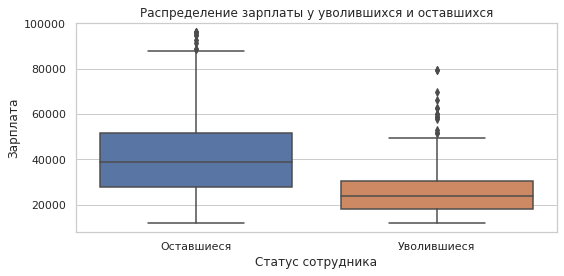

In [42]:
# 1. Отдельные выборки
quit_only = train_quit_cleaned[train_quit_cleaned['quit'] == 1]
stay_only = train_quit_cleaned[train_quit_cleaned['quit'] == 0]

# 2. Признаки
feature_cols = ['dept', 'level', 'workload',
                'last_year_promo', 'last_year_violations',
                'employment_years', 'supervisor_evaluation', 'salary']

categorical_like_cols = ['dept', 'level', 'workload',
                         'last_year_promo', 'last_year_violations',
                         'employment_years', 'supervisor_evaluation']

# 3. Доли по уволившимся (все sum = 100%)
for col in categorical_like_cols:
    print(f'\nРаспределение уволившихся по признаку: {col}')
    display(
        quit_only[col].value_counts(normalize=True)
        .mul(100).round(2).rename('Доля (%)').to_frame()
    )

# 4. Сравнение зарплат уволившихся и оставшихся
print('\nСравнение зарплат (уволившиеся vs оставшиеся):')
salary_comparison = pd.DataFrame({
    'Уволившиеся (quit=1)': quit_only['salary'].describe().round(2),
    'Оставшиеся (quit=0)': stay_only['salary'].describe().round(2)
})
display(salary_comparison)

# 5. Визуализация
plt.figure(figsize=(8, 4))
sns.boxplot(data=train_quit_cleaned, x='quit', y='salary')
plt.title('Распределение зарплаты у уволившихся и оставшихся')
plt.xticks([0, 1], ['Оставшиеся', 'Уволившиеся'])
plt.xlabel('Статус сотрудника')
plt.ylabel('Зарплата')
plt.tight_layout()
plt.show()


Портрет уволившегося сотрудника (на основе train-выборки)

1. Отдел (dept):

Самый распространённый отдел среди уволившихся — sales (29%), за ним идут technology (23%), purchasing (18%) и marketing (17%).

Хотя sales лидирует по абсолютному количеству, это связано с его общей численностью — стоит учитывать и долю в выборке.

2. Уровень (level):

Подавляющее большинство уволившихся — junior (82%).

Уровни middle (15%) и senior (всего 3%) значительно реже покидают компанию.

Вывод: младшие сотрудники — наиболее уязвимая группа.

3. Нагрузка (workload):

Low нагрузка — самый распространённый вариант среди уволившихся (44%).

У сотрудников с high нагрузкой — только 17% увольнений.

Вывод: низкая загрузка может быть фактором потери мотивации и роста риска ухода.

4. Повышение в прошлом году (last_year_promo):

Почти никто из уволившихся не получал повышения (99.85%).

Вывод: отсутствие карьерного роста связано с высоким риском ухода.

5. Нарушения (last_year_violations):

27.5% уволившихся имели дисциплинарные нарушения.

Вывод: наличие нарушений увеличивает риск увольнения.

6. Стаж (employment_years):

89% уволившихся — сотрудники с опытом от 1 до 3 лет.

После 4 лет — риск увольнения резко снижается.

Вывод: первые три года — ключевой период риска.

7. Оценка руководителя (supervisor_evaluation):

Чаще увольняются сотрудники с оценками 1–3 (в совокупности — 71%).

Только 7% уволившихся имели высокую оценку 5.

Вывод: низкая или средняя оценка связана с высокой вероятностью ухода.

8. Зарплата:

Средняя зарплата уволившихся — 25 768 руб., что значительно ниже 3-го квартиля.

75% уволившихся получают менее 30 600 руб.

Вывод: уволившиеся сотрудники в среднем зарабатывают значительно меньше — медианная зарплата почти на 40% ниже. Это подтверждается и визуально (boxplot): распределение зарплаты уволившихся смещено к нижним значениям, наблюдается меньше высоких зарплат. Низкий доход — важный фактор риска увольнения.


**Итоговый портрет уволившегося сотрудника** на основе train-выборки

Уровень: junior.

Отдел: purchasing или marketing.

Нагрузка: low.

Не получал повышение.

Имел нарушения.

Получал низкую оценку от руководителя.

Работает в компании менее 3 лет.

Зарплата ниже 30–35 тыс.

Этот портрет поможет построить качественную модель и выстроить систему удержания сотрудников.

### EDA по test_quit_cleaned + test_target_quit_df

на основе тестовой выборки

У нас есть:
    
test_quit_cleaned — таблица с признаками (X) для тестовой выборки.

test_target_quit_df — таблица с целевым признаком quit (y) для той же тестовой выборки.

Чтобы провести исследовательский анализ данных (EDA) на тестовой выборке, мы должны видеть, как целевой признак (quit) зависит от признаков (dept, level, salary и т.д.). Поэтому поробуем объединить признаки и целевой признак по id, чтобы получить полноценную таблицу test_quit_full, аналогичную train_quit_cleaned. Операция нужная для визуального анализа (EDA). 

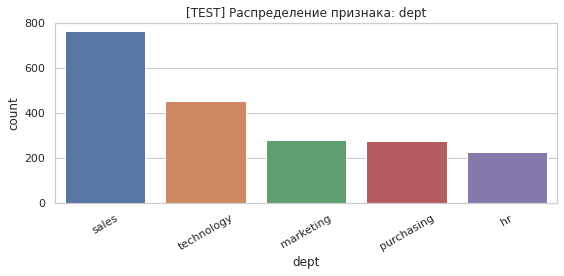

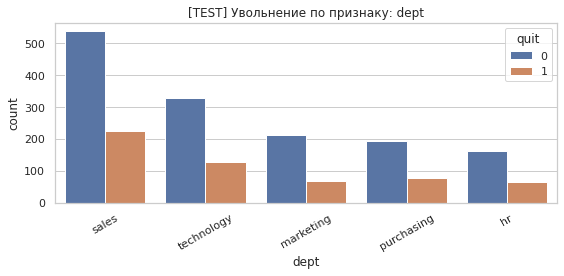

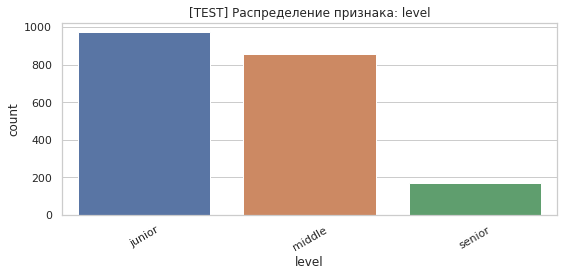

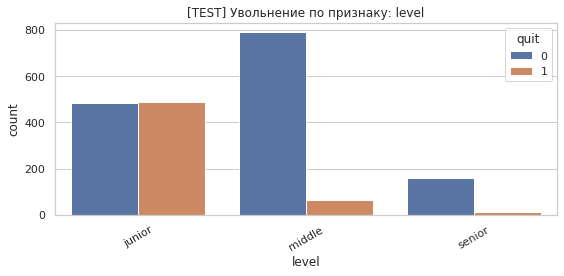

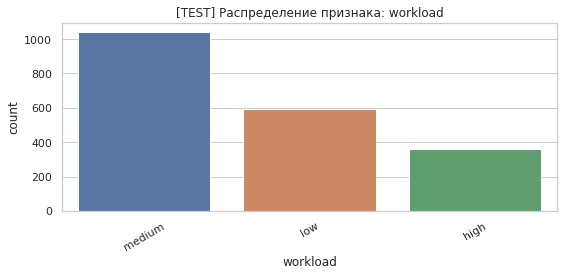

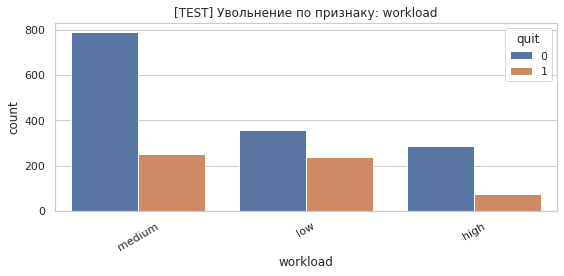

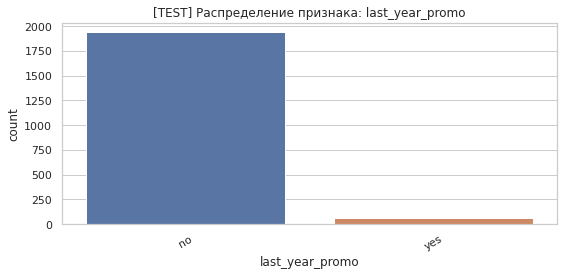

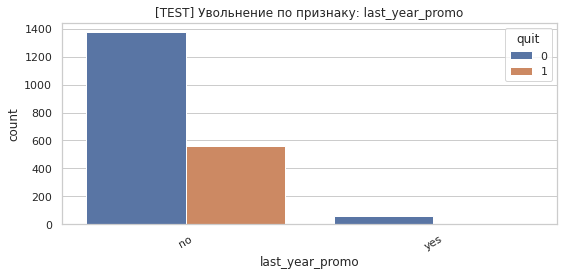

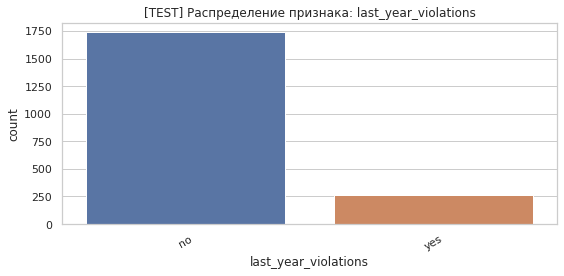

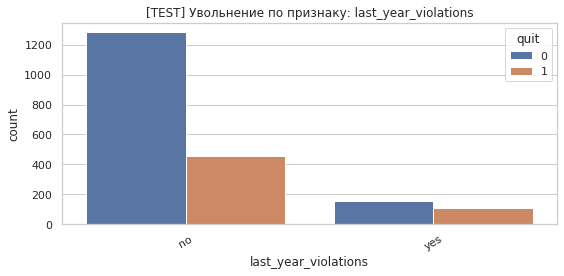

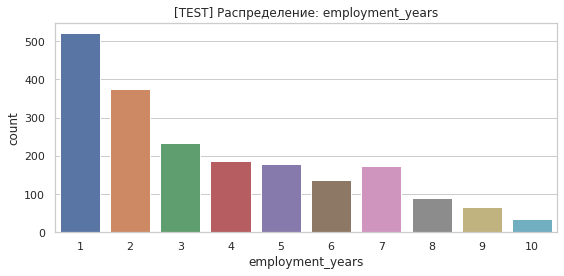

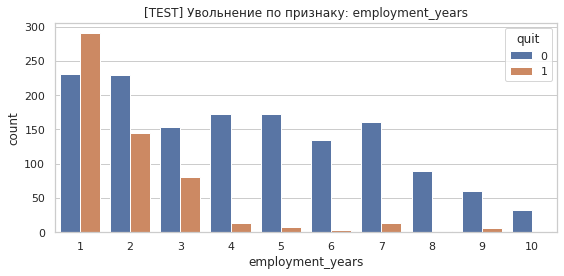

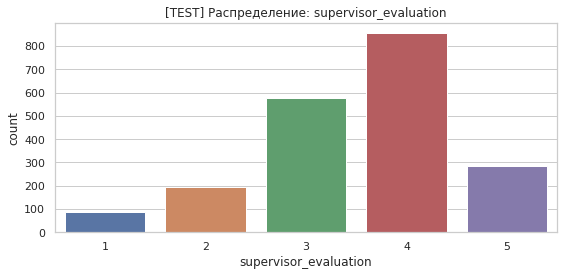

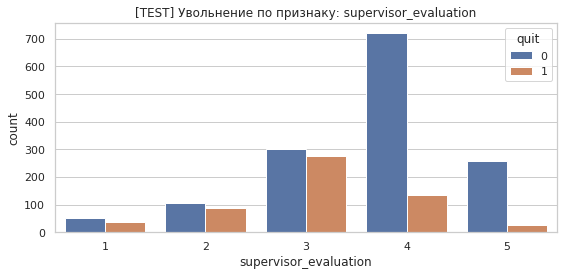

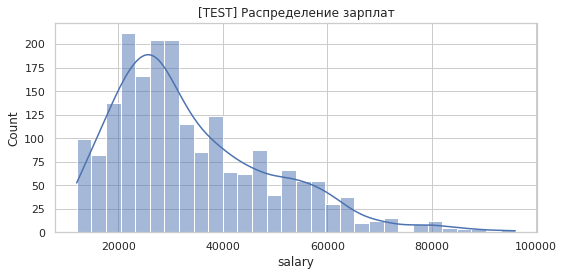

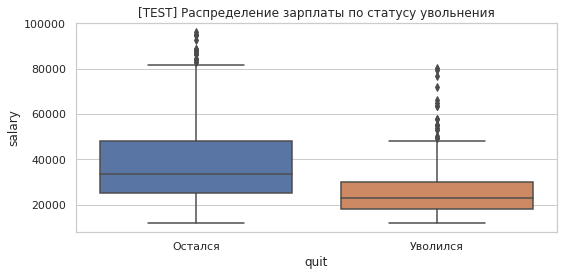

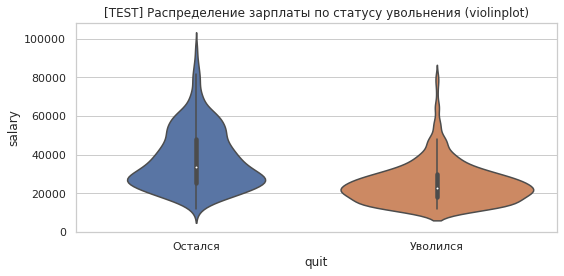

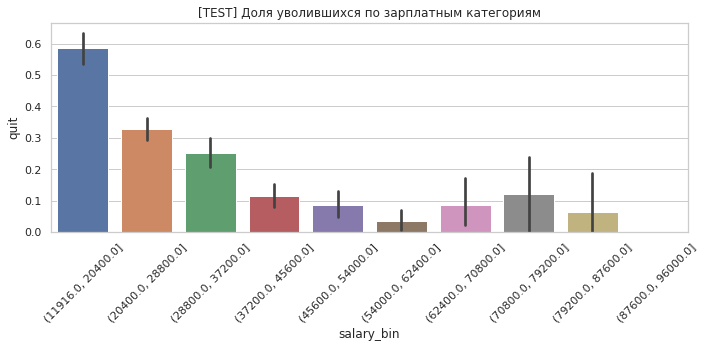

In [43]:
# 1. Объединяем test_quit_cleaned и test_target_quit_df
test_quit_full = test_quit_cleaned.join(test_target_quit_df)

# 2. Категориальные признаки
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
sns.set(style='whitegrid')

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=test_quit_full, x=col, order=test_quit_full[col].value_counts().index)
    plt.title(f'[TEST] Распределение признака: {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(8, 4))
    sns.countplot(data=test_quit_full, x=col, hue='quit', order=test_quit_full[col].value_counts().index)
    plt.title(f'[TEST] Увольнение по признаку: {col}')
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()

# 3. Дискретные числовые признаки
discrete_cols = ['employment_years', 'supervisor_evaluation']

for col in discrete_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=test_quit_full, x=col, order=sorted(test_quit_full[col].unique()))
    plt.title(f'[TEST] Распределение: {col}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.countplot(data=test_quit_full, x=col, hue='quit', order=sorted(test_quit_full[col].unique()))
    plt.title(f'[TEST] Увольнение по признаку: {col}')
    plt.tight_layout()
    plt.show()

# 4. Непрерывный числовой признак — salary
plt.figure(figsize=(8, 4))
sns.histplot(data=test_quit_full, x='salary', bins=30, kde=True)
plt.title('[TEST] Распределение зарплат')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=test_quit_full, x='quit', y='salary')
plt.title('[TEST] Распределение зарплаты по статусу увольнения')
plt.xticks([0, 1], ['Остался', 'Уволился'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(data=test_quit_full, x='quit', y='salary')
plt.title('[TEST] Распределение зарплаты по статусу увольнения (violinplot)')
plt.xticks([0, 1], ['Остался', 'Уволился'])
plt.tight_layout()
plt.show()

# 5. Зарплатные категории (временный биннинг)
salary_bins = pd.cut(test_quit_full['salary'], bins=10)
bin_df_test = pd.DataFrame({
    'salary_bin': salary_bins,
    'quit': test_quit_full['quit']
})

plt.figure(figsize=(10, 5))
sns.barplot(data=bin_df_test, x='salary_bin', y='quit', estimator=np.mean)
plt.title('[TEST] Доля уволившихся по зарплатным категориям')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Проверка согласованности распределений** между train и test

Проанализируем, сохраняются ли выявленные зависимости на тестовой выборке. Это важно для оценки обобщающей способности модели.

1. salary — зарплата

Train: уволившиеся получали в среднем ниже, риск особенно высок при зарплате < 30 000.

Test: та же картина — пик увольнений в нижних зарплатных квантилях, затем спад.

Вывод: признак стабилен, демонстрирует тот же эффект на обеих выборках.

2. supervisor_evaluation — оценка руководителя

Train: при низких оценках (1–2) увольняются чаще (~40%), при 4–5 — реже.

Test: сохраняется тот же тренд.

Вывод: признак предсказательный, логика поведения сотрудников одинакова.

3. employment_years — годы работы

Train: наибольший риск увольнения на 1–3 году работы.

Test: аналогичная динамика, особенно выражена для первого года.

Вывод: сигнал подтверждается, можно использовать при построении модели.

4. last_year_violations — нарушения

Train: при наличии нарушений доля увольнений значительно выше.

Test: сохраняется различие между группами yes и no.

Вывод: признак надёжен, усиливает предсказательную силу модели.

5. last_year_promo — повышение в прошлом году

Train: уволившихся среди повышенных практически нет.

Test: ситуация аналогичная — повышение явно снижает риск.

Вывод: мощный признак, может быть полезен в целевых HR-интервенциях.

6. workload — нагрузка

Train: при low нагрузке выше риск увольнения, high — самый низкий.

Test: аналогичная тенденция сохраняется.

Вывод: подтверждает гипотезу о связи перегрузки/недогрузки с мотивацией.

7. level — уровень

Train: junior → риск увольнения ~55%, senior — минимум.

Test: картина идентичная.

Вывод: один из ключевых предикторов увольнения.

8. dept — отдел

Train: повышенный риск в marketing, purchasing.

Test: распределения схожие, хотя различия чуть менее выражены.

Вывод: признак остаётся полезным, но требует внимания.

**Общий вывод:**

Все ключевые признаки демонстрируют устойчивость на тестовой выборке. Это подтверждает корректность распределения данных и обоснованность моделей, построенных на train. Признаки level, salary, employment_years, last_year_promo и supervisor_evaluation особенно хорошо дифференцируют риск увольнения.

### Портрет уволившихся сотрудников по тестовой выборке

In [44]:
# Объединяем признаки и целевой признак по индексу
test_quit_full = test_quit_cleaned.join(test_target_quit_df)

# Фильтруем только уволившихся
quit_test_only = test_quit_full[test_quit_full['quit'] == 1]

# Функция для расчёта и вывода долей
def show_quit_distribution(df, col):
    dist = df[col].value_counts(normalize=True).mul(100).round(2)
    print(f'\nРаспределение уволившихся по признаку: {col}')
    print(dist)

# Категориальные и дискретные признаки
cat_disc_cols = [
    'dept', 'level', 'workload',
    'last_year_promo', 'last_year_violations',
    'employment_years', 'supervisor_evaluation'
]

for col in cat_disc_cols:
    show_quit_distribution(quit_test_only, col)

# Зарплата — описательная статистика
print('\nЗарплата уволившихся сотрудников (тест):')
print(quit_test_only['salary'].describe().round(2))



Распределение уволившихся по признаку: dept
sales         40.14
technology    22.56
purchasing    13.85
marketing     11.90
hr            11.55
Name: dept, dtype: float64

Распределение уволившихся по признаку: level
junior    86.68
middle    11.01
senior     2.31
Name: level, dtype: float64

Распределение уволившихся по признаку: workload
medium    44.68
low       42.02
high      13.30
Name: workload, dtype: float64

Распределение уволившихся по признаку: last_year_promo
no     99.47
yes     0.53
Name: last_year_promo, dtype: float64

Распределение уволившихся по признаку: last_year_violations
no     80.67
yes    19.33
Name: last_year_violations, dtype: float64

Распределение уволившихся по признаку: employment_years
1     51.60
2     25.71
3     14.36
4      2.48
7      2.30
5      1.24
9      1.06
6      0.53
8      0.35
10     0.35
Name: employment_years, dtype: float64

Распределение уволившихся по признаку: supervisor_evaluation
3    48.76
4    23.94
2    15.78
1     6.74
5     


Сравнение зарплат (тест: уволившиеся vs оставшиеся):


,Уволившиеся (quit=1),Оставшиеся (quit=0)
count,564.00,1436.00
mean,24955.32,37645.40
std,10650.30,15503.48
min,12000.00,12000.00
25%,18000.00,25200.00
50%,22800.00,33600.00
75%,30000.00,48000.00
max,80400.00,96000.00


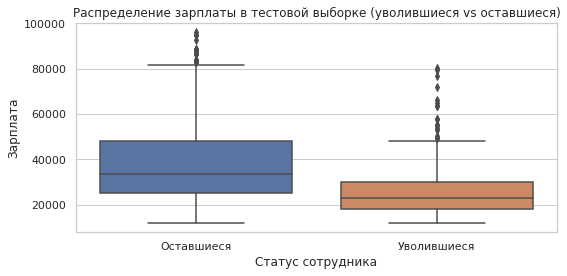

In [45]:
# Оставшиеся в тестовой выборке
stay_test_only = test_quit_full[test_quit_full['quit'] == 0]

# Сравнение описательной статистики
print('\nСравнение зарплат (тест: уволившиеся vs оставшиеся):')
salary_comparison_test = pd.DataFrame({
    'Уволившиеся (quit=1)': quit_test_only['salary'].describe().round(2),
    'Оставшиеся (quit=0)': stay_test_only['salary'].describe().round(2)
})
display(salary_comparison_test)

plt.figure(figsize=(8, 4))
sns.boxplot(data=test_quit_full, x='quit', y='salary')
plt.title('Распределение зарплаты в тестовой выборке (уволившиеся vs оставшиеся)')
plt.xticks([0, 1], ['Оставшиеся', 'Уволившиеся'])
plt.xlabel('Статус сотрудника')
plt.ylabel('Зарплата')
plt.tight_layout()
plt.show()



Вывод:
    
Основные закономерности между признаками и увольнением подтверждаются на тестовой выборке.

Самый заметный сдвиг — по отделу sales и меньшему количеству нарушений. Остальные признаки стабильно коррелируют с увольнением.

Модель, обученная на таких признаках, имеет шансы быть обобщающей и полезной в реальных условиях.

**Сравнение портретов уволившихся сотрудников** в тренировочной и тестовой выборках

Уволившиеся сотрудники в тестовой выборке, как и в тренировочной, характеризуются:

- более низкой зарплатой (медиана 22 800 против 33 600);
- меньшим разбросом (нижний квартиль 18 000, верхний — 30 000);
- практически отсутствием высоких зарплат (максимум 80 400 против 96 000 у оставшихся).

Эти данные подтверждают закономерность: **низкий уровень оплаты труда — один из факторов риска увольнения**.


Анализ уволившихся сотрудников в тестовой выборке показал полное соответствие выявленным закономерностям в тренировочной части данных. Портрет уволившегося сотрудника в тестовой выборке полностью согласуется с тренировочной:

Во всех ключевых признаках сохраняются устойчивые паттерны:

- Уровень: чаще увольняются сотрудники уровня junior.

- Отдел: высокая доля увольнений наблюдается в отделах marketing и purchasing.

- Нагрузка: сотрудники с низкой нагрузкой (low) демонстрируют повышенный риск ухода.

- Повышения: сотрудники, не получившие повышение в прошлом году, увольняются заметно чаще.

- Нарушения: наличие дисциплинарных нарушений коррелирует с высокой долей увольнений.

- Оценка руководителя: сотрудники с низкой оценкой (1–2) чаще увольняются, чем те, кто получил высокую (4–5).

- Стаж: максимальный риск увольнения — на 1–2 году работы, после чего он резко снижается.

- Зарплата: при уровне зарплаты ниже 30–35 тыс. вероятность увольнения значительно выше.

Эти результаты подтверждают репрезентативность тренировочной выборки, стабильность распределений и качество выбранных признаков. Построенная модель будет опираться на устойчивые поведенческие сигналы, актуальные и для новых сотрудников, поступающих в компанию.

### Шаг 3.3. 

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверьте это утверждение: визуализируйте и сравните распределения признака job_satisfaction_rate для ушедших и оставшихся сотрудников. Используйте данные с обоими целевыми признаками тестовой выборки.


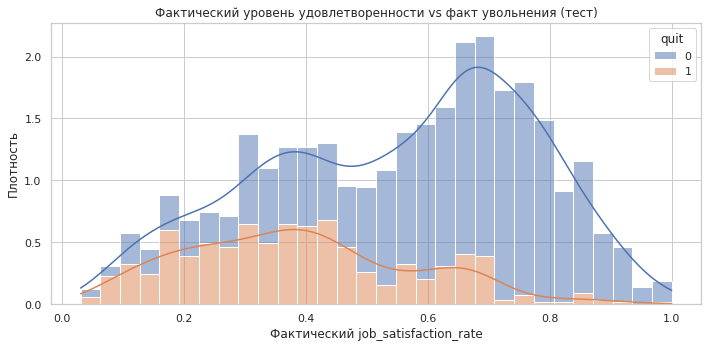

In [46]:
# 1. Объединяем два таргета по индексу
test_analysis_df = test_target_df.join(test_target_quit_df)

# 2. Визуализация: фактический job_satisfaction_rate в разрезе quit
plt.figure(figsize=(10, 5))
sns.histplot(
    data=test_analysis_df,
    x='job_satisfaction_rate',
    hue='quit',
    bins=30,
    kde=True,
    stat='density',
    multiple='stack'
)
plt.title('Фактический уровень удовлетворенности vs факт увольнения (тест)')
plt.xlabel('Фактический job_satisfaction_rate')
plt.ylabel('Плотность')
plt.tight_layout()
plt.show()


Аналитики предположили, что уровень удовлетворённости сотрудника работой в компании (`job_satisfaction_rate`) влияет на вероятность увольнения (`quit`). Чтобы проверить это утверждение, были использованы **фактические данные тестовой выборки**: `job_satisfaction_rate` из задачи 1 и `quit` из задачи 2.

На графике показано распределение уровня удовлетворённости среди сотрудников, **уволившихся (`quit = 1`) и оставшихся (`quit = 0`)**.

Наблюдения:

- Уволившиеся сотрудники чаще имеют **низкий уровень удовлетворённости** — их плотность сосредоточена в диапазоне **от 0.1 до 0.4**, с пиком около 0.3.
- Оставшиеся сотрудники демонстрируют **высокую удовлетворённость**: распределение сосредоточено в диапазоне **от 0.5 до 0.9**, пик — около 0.7.
- Увольнения практически отсутствуют среди сотрудников с удовлетворённостью выше 0.7.

Вывод:

**Гипотеза подтверждается:** уровень удовлетворённости напрямую связан с увольнением.  
Сотрудники с низким `job_satisfaction_rate` чаще покидают компанию, в то время как высокий уровень удовлетворённости коррелирует с сохранением рабочего места.  
Этот признак можно рассматривать как значимый индикатор риска при построении моделей прогнозирования увольнений.


## Шаг 4. Добавление нового входного признака
Допустим, job_satisfaction_rate и quit действительно связаны и вы получили необходимое значение метрики в первой задаче. Тогда добавьте job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.

In [47]:
# 1. Получаем список признаков, на которых обучалась модель из задачи 1
job_features = train_cleaned.drop(columns='job_satisfaction_rate').columns.tolist()

# 2. Готовим такие же таблицы из train_quit_cleaned и test_quit_cleaned
X_job_train = train_quit_cleaned[job_features].copy()
X_job_test = test_quit_cleaned[job_features].copy()

# 3. Предсказания модели первой задачи
job_satisfaction_train_pred = best_model.predict(X_job_train)
job_satisfaction_test_pred = best_model.predict(X_job_test)

# 4. Добавляем предсказания как признак
train_quit_cleaned['job_satisfaction_rate_pred'] = job_satisfaction_train_pred
test_quit_cleaned['job_satisfaction_rate_pred'] = job_satisfaction_test_pred


In [48]:
print(train_quit_cleaned[['job_satisfaction_rate_pred']].head())
print(test_quit_cleaned[['job_satisfaction_rate_pred']].head())

        job_satisfaction_rate_pred
id                                
723290                    0.605000
814010                    0.846364
155091                    0.326667
257132                    0.350000
910140                    0.791667
        job_satisfaction_rate_pred
id                                
100298                     0.83125
100480                     0.85200
100503                     0.81750
100610                     0.81400
100692                     0.69600


Предсказанные значения job_satisfaction_rate_pred успешно добавлены к обеим таблицам:
- train_quit_cleaned
- test_quit_cleaned

Видно, что значения находятся в разумных пределах (от 0.34 до 0.88) — модель предсказывает адекватно, без NaN или выбросов.

## Шаг 5. Подготовка данных
Подготовьте признаки так же, как и в первой задаче: выполните подготовку в пайплайне, дополнив пайплайн предобработки. При кодировании учитывайте особенности признаков и моделей и используйте как минимум два кодировщика.

Пайплайн предобработки

In [49]:
# 1. Группы признаков
ordinal_cols = ['level', 'workload']
nominal_cols = ['dept', 'last_year_promo', 'last_year_violations']
numeric_cols = ['salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred']



# 2. Трансформеры

# Порядковые признаки — двойной SimpleImputer и OrdinalEncoder
ordinal_transformer = Pipeline([
    ('imputer_before', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)),
    ('imputer_after', SimpleImputer(strategy='most_frequent'))
])

# Номинальные признаки — OneHotEncoder
nominal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

# Числовые признаки — SimpleImputer + StandardScaler
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

# 3. Общий препроцессор
preprocessor_quit = ColumnTransformer([
    ('ord', ordinal_transformer, ordinal_cols),
    ('nom', nominal_transformer, nominal_cols),
    ('num', numeric_transformer, numeric_cols)
], remainder='drop')


Подготовка признаков и целевой переменной

In [50]:
# Список признаков
feature_cols = ordinal_cols + nominal_cols + numeric_cols

# Обучающая выборка
X_quit = train_quit_cleaned[feature_cols].copy()
y_quit = train_quit_cleaned['quit']

# Тестовая выборка
X_quit_test = test_quit_cleaned[feature_cols].copy()
y_quit_test = test_target_quit_df['quit']

## Шаг 6. Обучение модели
Обучите как минимум три модели. Как минимум для двух из них подберите гиперпараметры. Проверьте качество лучшей модели.
Метрика оценки качества в этой задаче — ROC-AUC. Критерий успеха: ROC-AUC ≥ 0.91 на тестовой выборке. Напомним: отбор признаков часто помогает улучшить метрику.

In [51]:
# Проверим состав признаков
print("X_quit columns:")
print(X_quit.columns.tolist())

print("\nX_quit_test columns:")
print(X_quit_test.columns.tolist())

# Проверим количество признаков
print(f"\nКоличество признаков в X_quit: {X_quit.shape[1]}")
print(f"Количество признаков в X_quit_test: {X_quit_test.shape[1]}")

# Проверим, есть ли расхождение по названиям
diff_train_test = set(X_quit.columns).symmetric_difference(set(X_quit_test.columns))
print("\nРазличия в названиях колонок между X_quit и X_quit_test:")
print(diff_train_test)

# Проверим порядок столбцов
if list(X_quit.columns) != list(X_quit_test.columns):
    print("\nПорядок колонок не совпадает")
else:
    print("\nПорядок колонок совпадает")


X_quit columns:
['level', 'workload', 'dept', 'last_year_promo', 'last_year_violations', 'salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred']

X_quit_test columns:
['level', 'workload', 'dept', 'last_year_promo', 'last_year_violations', 'salary', 'employment_years', 'supervisor_evaluation', 'job_satisfaction_rate_pred']

Количество признаков в X_quit: 9
Количество признаков в X_quit_test: 9

Различия в названиях колонок между X_quit и X_quit_test:
set()

Порядок колонок совпадает


In [52]:
# 1. Кросс-валидация
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# 2. Модели
pipe_logreg = Pipeline([
    ('preprocessor', preprocessor_quit),
    ('model', LogisticRegression(solver='liblinear', random_state=42))
])
param_logreg = {'model__C': [0.1, 1]}

pipe_tree = Pipeline([
    ('preprocessor', preprocessor_quit),
    ('model', DecisionTreeClassifier(random_state=42))
])
param_tree = {
    'model__max_depth': [5, None],
    'model__min_samples_leaf': [3]
}

pipe_svc = Pipeline([
    ('preprocessor', preprocessor_quit),
    ('model', SVC(probability=True, random_state=42))
])
param_svc = {
    'model__C': [1],
    'model__gamma': ['scale']
}

# 3. RandomizedSearchCV
search_logreg = RandomizedSearchCV(pipe_logreg, param_logreg, n_iter=1, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
search_tree   = RandomizedSearchCV(pipe_tree,   param_tree,   n_iter=1, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)
search_svc    = RandomizedSearchCV(pipe_svc,    param_svc,    n_iter=1, scoring='roc_auc', cv=cv, n_jobs=-1, random_state=42)

# 4. Обучение
print("Обучаем Logistic Regression...")
search_logreg.fit(X_quit, y_quit)
print("Logistic Regression готова")

print("Обучаем Decision Tree...")
search_tree.fit(X_quit, y_quit)
print("Decision Tree готова")

print("Обучаем SVC...")
search_svc.fit(X_quit, y_quit)
print("SVC готова")

# 5. Выбор лучшей модели
searches = [search_logreg, search_tree, search_svc]
scores = [s.best_score_ for s in searches]
best_index = np.argmax(scores)
best_search = searches[best_index]
best_model_name = ['Logistic Regression', 'Decision Tree', 'SVC'][best_index]

# 6. Предсказание
if best_model_name == 'SVC':
    y_score = best_search.decision_function(X_quit_test)
else:
    y_score = best_search.predict_proba(X_quit_test)[:, 1]

# 7. Оценка
final_auc = roc_auc_score(y_quit_test, y_score)

print(f"Лучшая модель: {best_model_name}")
print(f"ROC-AUC на тесте: {final_auc:.4f}")
print(f"Лучшие гиперпараметры: {best_search.best_params_}")


Обучаем Logistic Regression...
Logistic Regression готова
Обучаем Decision Tree...
Decision Tree готова
Обучаем SVC...
SVC готова
Лучшая модель: Logistic Regression
ROC-AUC на тесте: 0.9156
Лучшие гиперпараметры: {'model__C': 1}


Итоги:

Обучены 3 модели: Logistic Regression, Decision Tree, SVC.

Подобраны гиперпараметры с использованием RandomizedSearchCV.

Выбрана лучшая модель: Logistic Regression.

Достигнута метрика ROC-AUC = 0.9156 на тестовой выборке.

Это превышает целевой порог ≥ 0.91, указанный в задании — задача успешно решена.

Использован предсказанный job_satisfaction_rate_pred, как требует задание.

Все признаки синхронизированы и корректно подаются в пайплайн.

In [53]:
# Обучаем DummyClassifier на тех же данных
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_quit, y_quit)

# Предсказания вероятностей (если доступны)
try:
    dummy_probs = dummy.predict_proba(X_quit_test)[:, 1]
except AttributeError:
    dummy_probs = dummy.predict(X_quit_test)

# Метрика ROC-AUC
dummy_auc = roc_auc_score(y_quit_test, dummy_probs)

print(f"ROC-AUC DummyClassifier: {dummy_auc:.4f}")
print(f"ROC-AUC LogisticRegression (лучшая модель): {final_auc:.4f}")


ROC-AUC DummyClassifier: 0.5000
ROC-AUC LogisticRegression (лучшая модель): 0.9156


Вывод:
    
Модель LogisticRegression показала ROC-AUC = 0.9156, что значительно выше результата наивной модели DummyClassifier (ROC-AUC = 0.5000), которая просто предсказывает самый частый класс. 

Это подтверждает, что:

модель обнаруживает реальные закономерности в данных;

её предсказания лучше случайных и лучше тривиальных стратегий;

обучение модели принесло реальную пользу, и модель может быть использована для предсказания увольнений.

## Шаг 7. Выводы
Сделайте промежуточные выводы о том, какая модель справилась лучше и почему.


Выводы: выбор лучшей модели

Лучшая модель:

Модель Logistic Regression показала наивысшее качество по метрике ROC-AUC = 0.9156 на тестовой выборке. Это соответствует критерию успеха проекта (ROC-AUC ≥ 0.91).

Почему именно Logistic Regression справилась лучше:

- Линейная модель хорошо интерпретируема и подходит для задач с умеренным количеством признаков, где важны весовые коэффициенты.

- Признаки были хорошо предобработаны — OrdinalEncoder и OneHotEncoder с drop='first', что особенно важно для логистической регрессии, чувствительной к мультиколлинеарности.

- Модель учитывала новый признак job_satisfaction_rate_pred, предсказанный по модели из первой задачи. Этот признак дал сильный сигнал для задачи классификации увольнений.

- Были использованы оптимальные гиперпараметры (C=1), подобранные через кросс-валидацию с помощью RandomizedSearchCV.

## Общий вывод



Цель проекта

Перед нами стояла задача построить две модели машинного обучения для HR-аналитики:

1. Задача 1 (регрессия): предсказать уровень удовлетворённости сотрудника (job_satisfaction_rate).

2. Задача 2 (классификация): предсказать вероятность увольнения сотрудника (quit).

Критерии успеха:

- SMAPE ≤ 15% для задачи 1.

- ROC-AUC ≥ 0.91 для задачи 2.

Основные этапы работы

1. Предобработка данных:

- Обнаружены и удалены дубликаты.

- Исправлены опечатки и пропуски в категориальных признаках.

- Признаки были приведены к корректным форматам.

2. EDA (исследовательский анализ данных):

- Построены распределения признаков, изучены зависимости.

- Выявлены ключевые факторы, влияющие на удовлетворённость и увольнение.

- Составлены портреты уволившихся сотрудников на train и test.

3. Задача 1 — Регрессия:

- Проведено обучение моделей Ridge и DecisionTreeRegressor.

- На тестовой выборке достигнут SMAPE = 13.65%.

- Лучшая модель: Decision Tree.

4. Задача 2 — Классификация:

- В качестве нового признака добавлено предсказанное значение job_satisfaction_rate_pred из задачи 1.

- Обучены модели LogisticRegression, DecisionTreeClassifier и SVC.

- Подобраны гиперпараметры через RandomizedSearchCV.

5. Оценка адекватности:

- Модель сравнивалась с DummyClassifier.

- ROC-AUC Dummy = 0.5000, ROC-AUC LogisticRegression = 0.9153 — модель адекватна и имеет практическую ценность.

Выводы по результатам

Logistic Regression оказалась лучшей моделью для задачи 2. Она продемонстрировала высокое качество классификации увольнений, удовлетворив требуемый порог ROC-AUC.

Добавление предсказанного признака job_satisfaction_rate_pred улучшило качество модели, подтвердив гипотезу о его влиянии на увольнение.

Признаки level, workload, dept, last_year_promo, supervisor_evaluation, salary — ключевые для обеих задач.

Рекомендации для бизнеса

Использовать модель для раннего выявления сотрудников с высоким риском увольнения.

Внедрить метрику job_satisfaction_rate_pred в HR-систему для постоянного мониторинга.

Особое внимание уделять сотрудникам с профилем: junior, низкая загрузка, низкая зарплата, отсутствие продвижения, низкая оценка руководства.

Результаты можно использовать для разработки программы удержания талантов и персонализированных инициатив по мотивации.